In [1]:
from os import path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Base directory to save figures
FIG_DIR = r"/Users/chase/Desktop/MindScope/Documents/v1dd-chase/analysis_presentations/2022-10-06-group_meeting/figures"

In [3]:
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
base_folder = "/Volumes/AllenDrive/v1dd/data" # Chase's external hard drive
# base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = OPhysClient(base_folder)

In this notebook, we load all sessions for mouse 409828 and compute metrics on them

In [4]:
mouse = 409828 # selected for EM
column = 1

session_ids = client.get_all_session_ids()
# session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column) and s[9] == "3"]
session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column)]

print("Sessions to load:")
print(session_ids)

Sessions to load:
[]


In [5]:
sessions = []

for session_id in tqdm(session_ids):
    session = client.load_ophys_session(session_id=session_id)
    sessions.append(session)

print(f"Loaded {len(sessions)} ophys sessions")

100%|██████████| 15/15 [00:17<00:00,  1.16s/it]

Loaded 15 ophys sessions


In [6]:
plane_info = [] # holds (mouse, column, volume, plane)
dg_full = []
dg_windowed = []

with tqdm(desc="Loading DG analyses", total=sum(len(s.get_planes()) for s in sessions)) as pbar:
    for session in sessions:
        for plane in session.get_planes():
            plane_info.append((session.get_mouse_id(), session.get_column_id(), session.get_volume_id(), plane))
            dg_full.append(DriftingGratings(session, plane, dg_type="full"))
            dg_windowed.append(DriftingGratings(session, plane, dg_type="windowed"))
            dg_full[-1].fit_tuning_curve = False
            dg_windowed[-1].fit_tuning_curve = False
            pbar.update()

Loading DG analyses: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


# Compute response metrics (this takes a while)

In [7]:
RECOMPUTE_METRICS = False
DF_SAVE_DIR = r"/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes"
dg_full_metrics_file = path.join(DF_SAVE_DIR, "dg_full_metrics_col1.csv")
dg_windowed_metrics_file = path.join(DF_SAVE_DIR, "dg_windowed_metrics_col1.csv")
ss_metrics_file = path.join(DF_SAVE_DIR, "ss_metrics_col1.csv")

if RECOMPUTE_METRICS:
    # Reset
    # for dg in dg_full: dg._metrics = None
    # for dg in dg_windowed: dg._metrics = None

    # Concatenate across the different planes
    print("Concatenating DG-full metrics...")
    dg_full_metrics = StimulusAnalysis.concat_metrics(dg_full)
    print("Merging DG-windowed metrics...")
    dg_windowed_metrics = StimulusAnalysis.concat_metrics(dg_windowed)
    print("Done.", len(dg_full_metrics), "total ROIs.")
    dg_full_metrics.to_csv(dg_full_metrics_file)
    dg_windowed_metrics.to_csv(dg_windowed_metrics_file)

    print("Computing surround suppression metrics...")
    ss_metrics = DriftingGratings.compute_surround_suppression_metrics(dg_full, dg_windowed)
    ss_metrics.to_csv(ss_metrics_file)
else:
    dg_full_metrics = pd.read_csv(dg_full_metrics_file, index_col=0, low_memory=False)#.convert_dtypes()
    dg_windowed_metrics = pd.read_csv(dg_windowed_metrics_file, index_col=0, low_memory=False)#.convert_dtypes()
    ss_metrics = pd.read_csv(ss_metrics_file, index_col=0, low_memory=False)

    def fix_str_int(val):
        try:
            return int(val)
        except:
            return val
    
    # Fix volume column
    for df in (dg_full_metrics, dg_windowed_metrics, ss_metrics):
        df.volume = df.volume.apply(fix_str_int)

dg_full_metrics

mouse  column volume  plane   roi  depth  is_valid  \
M409828_11_1_0     409828       1      1      1     0     50     False   
M409828_11_1_1     409828       1      1      1     1     50     False   
M409828_11_1_2     409828       1      1      1     2     50     False   
M409828_11_1_3     409828       1      1      1     3     50     False   
M409828_11_1_4     409828       1      1      1     4     50     False   
...                   ...     ...    ...    ...   ...    ...       ...   
M409828_1f_1_1186  409828       1      f      1  1186    725     False   
M409828_1f_1_1187  409828       1      f      1  1187    725     False   
M409828_1f_1_1188  409828       1      f      1  1188    725     False   
M409828_1f_1_1189  409828       1      f      1  1189    725     False   
M409828_1f_1_1190  409828       1      f      1  1190    725     False   

                   is_responsive  pref_dir  pref_sf  ...  osi_naive  \
M409828_11_1_0             False       NaN      NaN  ...        NaN   
M409828_11_1_1             False       NaN      NaN  ...        NaN   
M409828_11_1_2             False       NaN      NaN  ...        NaN   
M409828_11_1_3             False       NaN      NaN  ...        NaN   
M409828_11_1_4             False       NaN      NaN  ...        NaN   
...                          ...       ...      ...  ...        ...   
M409828_1f_1_1186          False       NaN      NaN  ...        NaN   
M409828_1f_1_1187          False       NaN      NaN  ...        NaN   
M409828_1f_1_1188          False       NaN      NaN  ...        NaN   
M409828_1f_1_1189          False       NaN      NaN  ...        NaN   
M409828_1f_1_1190          False       NaN      NaN  ...        NaN   

                   frac_responsive_trials  frac_responsive_trials_naive  \
M409828_11_1_0                        NaN                           NaN   
M409828_11_1_1                        NaN                           NaN   
M409828_11_1_2                        NaN                           NaN   
M409828_11_1_3                        NaN                           NaN   
M409828_11_1_4                        NaN                           NaN   
...                                   ...                           ...   
M409828_1f_1_1186                     NaN                           NaN   
M409828_1f_1_1187                     NaN                           NaN   
M409828_1f_1_1188                     NaN                           NaN   
M409828_1f_1_1189                     NaN                           NaN   
M409828_1f_1_1190                     NaN                           NaN   

                   is_responsive_naive  lifetime_sparseness  \
M409828_11_1_0                     NaN                  NaN   
M409828_11_1_1                     NaN                  NaN   
M409828_11_1_2                     NaN                  NaN   
M409828_11_1_3                     NaN                  NaN   
M409828_11_1_4                     NaN                  NaN   
...                                ...                  ...   
M409828_1f_1_1186                  NaN                  NaN   
M409828_1f_1_1187                  NaN                  NaN   
M409828_1f_1_1188                  NaN                  NaN   
M409828_1f_1_1189                  NaN                  NaN   
M409828_1f_1_1190                  NaN                  NaN   

                   p_trial_responses  sig_trial_responses  pref_ori  \
M409828_11_1_0                   NaN                  NaN       NaN   
M409828_11_1_1                   NaN                  NaN       NaN   
M409828_11_1_2                   NaN                  NaN       NaN   
M409828_11_1_3                   NaN                  NaN       NaN   
M409828_11_1_4                   NaN                  NaN       NaN   
...                              ...                  ...       ...   
M409828_1f_1_1186                NaN                  NaN       NaN   
M409828_1f_1_1187                NaN                

### ***Important!*** Only consider the valid ROIs!

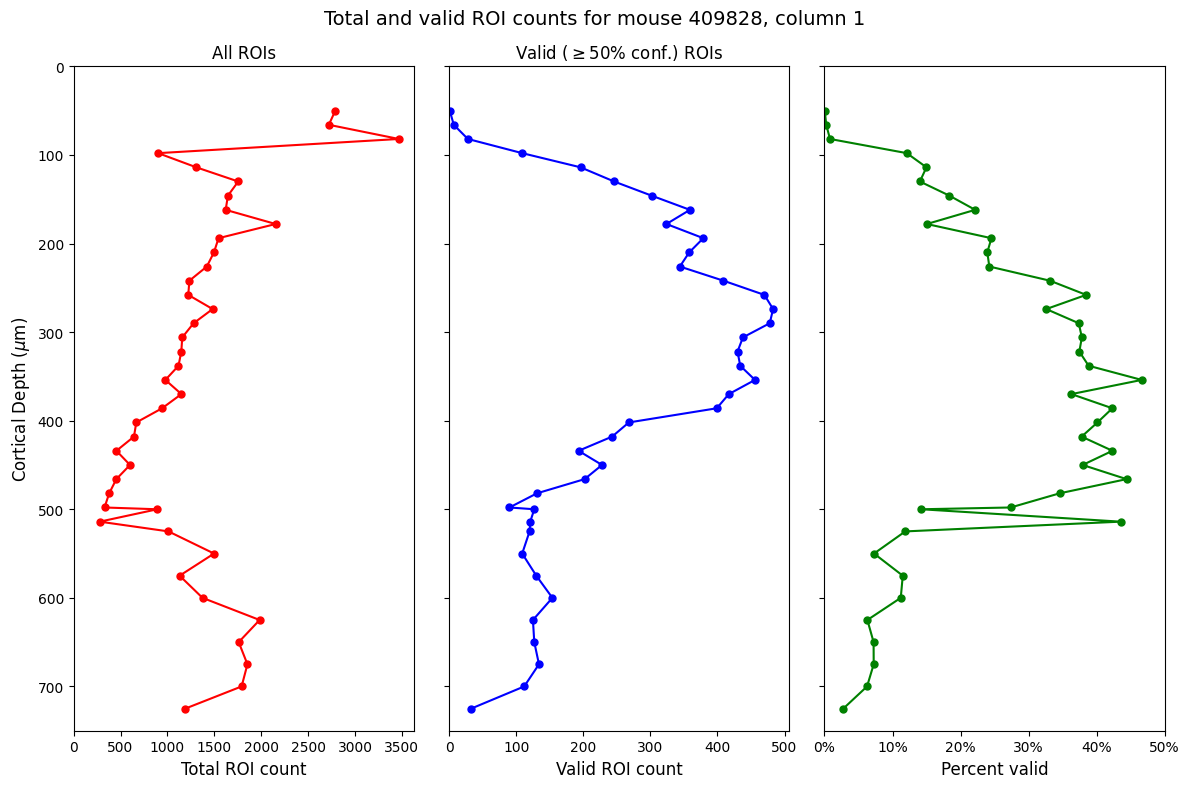

In [8]:
# This must be run before metrics are constrained to only valid ROIs (in subsequent cell)
fig, axs = plt.subplots(figsize=(12, 8), ncols=3, facecolor="white")
ax_all, ax_valid, ax_frac_valid = axs

all_counts = dg_full_metrics["depth"].value_counts().sort_index()
valid_counts = dg_full_metrics[dg_full_metrics.is_valid]["depth"].value_counts().sort_index()
valid_rates = valid_counts / all_counts

ax_all.plot(all_counts.values, all_counts.index, color="red", marker=".", markersize=10)
ax_all.set_ylabel("Cortical Depth ($\mu$m)", fontsize=12)
ax_all.set_xlabel("Total ROI count", fontsize=12)
ax_all.set_title("All ROIs")

ax_valid.plot(valid_counts.values, valid_counts.index, color="blue", marker=".", markersize=10)
ax_valid.set_title("Valid ($\geq 50$% conf.) ROIs")
ax_valid.set_xlabel("Valid ROI count", fontsize=12)
ax_valid.set_yticklabels([])

ax_frac_valid.plot(valid_rates.values, valid_rates.index, color="green", marker=".", markersize=10)
ax_frac_valid.set_xlabel("Percent valid", fontsize=12)
ax_frac_valid.set_yticklabels([])
ax_frac_valid.set_xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], labels=["0%", "10%", "20%", "30%", "40%", "50%"])

plt.setp(axs, ylim=(750, 0)) # y-axis counts downwards
for ax in axs:
    ax.set_xlim(0, ax.get_xlim()[1])
fig.suptitle(f"Total and valid ROI counts for mouse {mouse}, column {column}", fontsize=14)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/roi_counts_all_valid.png")

In [9]:
is_valid = dg_full_metrics.is_valid & dg_windowed_metrics.is_valid
dg_full_metrics = dg_full_metrics.loc[is_valid]
dg_windowed_metrics = dg_windowed_metrics.loc[is_valid]
ss_metrics = ss_metrics.loc[is_valid]
n_valid, n_tot = np.count_nonzero(is_valid), len(is_valid)
print(f"{n_valid}/{n_tot} ({n_valid/n_tot*100:.1f}%) ROIs are valid")
dg_full_metrics

9714/52826 (18.4%) ROIs are valid


mouse  column volume  plane  roi  depth  is_valid  \
M409828_11_1_89  409828       1      1      1   89     50      True   
M409828_11_2_0   409828       1      1      2    0     66      True   
M409828_11_2_1   409828       1      1      2    1     66      True   
M409828_11_2_2   409828       1      1      2    2     66      True   
M409828_11_2_4   409828       1      1      2    4     66      True   
...                 ...     ...    ...    ...  ...    ...       ...   
M409828_1f_1_67  409828       1      f      1   67    725      True   
M409828_1f_1_69  409828       1      f      1   69    725      True   
M409828_1f_1_70  409828       1      f      1   70    725      True   
M409828_1f_1_74  409828       1      f      1   74    725      True   
M409828_1f_1_90  409828       1      f      1   90    725      True   

                 is_responsive  pref_dir  pref_sf  ...  osi_naive  \
M409828_11_1_89          False       330     0.08  ...   0.097664   
M409828_11_2_0            True         0     0.04  ...   0.096842   
M409828_11_2_1            True         0     0.08  ...   0.768465   
M409828_11_2_2            True       120     0.04  ...   0.124415   
M409828_11_2_4            True       240     0.04  ...   0.049413   
...                        ...       ...      ...  ...        ...   
M409828_1f_1_67           True        90     0.04  ...   0.216378   
M409828_1f_1_69          False       270     0.04  ...    0.28384   
M409828_1f_1_70           True       150     0.08  ...   0.336228   
M409828_1f_1_74          False       270     0.04  ...   0.203873   
M409828_1f_1_90           True       270     0.04  ...   0.150105   

                 frac_responsive_trials  frac_responsive_trials_naive  \
M409828_11_1_89                   0.125                         0.125   
M409828_11_2_0                 0.285714                      0.428571   
M409828_11_2_1                    0.875                         0.875   
M409828_11_2_2                    0.625                         0.625   
M409828_11_2_4                     0.25                          0.25   
...                                 ...                           ...   
M409828_1f_1_67                   0.375                           0.2   
M409828_1f_1_69                     0.2                          0.25   
M409828_1f_1_70                   0.625                         0.625   
M409828_1f_1_74                     0.2                         0.375   
M409828_1f_1_90                     0.4                           0.4   

                 is_responsive_naive  lifetime_sparseness  p_trial_responses  \
M409828_11_1_89                False              0.60838           0.008468   
M409828_11_2_0                  True             0.634665           0.500816   
M409828_11_2_1                  True             0.848415                0.0   
M409828_11_2_2                  True             0.620144            0.60647   
M409828_11_2_4                  True             0.632735           0.024927   
...                              ...                  ...                ...   
M409828_1f_1_67                False             0.615998           0.077171   
M409828_1f_1_69                 True             0.796495           0.624346   
M409828_1f_1_70                 True             0.700441           0.193052   
M409828_1f_1_74                 True             0.700717           0.226142   
M409828_1f_1_90                 True             0.596091           0.035463   

                 sig_trial_responses  pref_ori  pref_ori_naive  \
M409828_11_1_89                 True       150             150   
M409828_11_2_0                 False         0              90   
M409828_11_2_1                  True         0               0   
M409828_11_2_2                 False       120             120   
M409828_11_2_4                  True        60              60   
...                              ...       ...             ...   
M409828_1f_1_67                False

In [18]:
same_pref_cond = ((dg_full_metrics.pref_dir == dg_full_metrics.pref_dir_naive) & (dg_full_metrics.pref_sf == dg_full_metrics.pref_sf_naive))
print("all", same_pref_cond.mean())
print("is_responsive", same_pref_cond[dg_full_metrics.is_responsive & dg_windowed_metrics.is_responsive].mean())
print("is_responsive naive", same_pref_cond[dg_full_metrics.is_responsive_naive & dg_windowed_metrics.is_responsive_naive].mean())
print("z_score", same_pref_cond[(dg_full_metrics.z_score > 2) & (dg_windowed_metrics.z_score > 2)].mean())

all 0.6966234301008853
is_responsive 0.8084210526315789
is_responsive naive 0.7625704151888171
z_score 0.7944647071443897


In [10]:
resp_full = dg_full_metrics.is_responsive
resp_windowed = dg_windowed_metrics.is_responsive
n_tot = len(dg_full_metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(resp_full, resp_windowed).value_counts()[True]
n_full = resp_full.value_counts()[True]
n_windowed = resp_windowed.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = (resp_full | resp_windowed).value_counts()[True]
n_neither = np.logical_and(~resp_full, ~resp_windowed).value_counts()[True]

print(f"{n_full}/{n_tot} ({n_full/n_tot*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_tot} ({n_windowed/n_tot*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_tot} ({n_either/n_tot*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_tot} ({n_both/n_tot*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_tot} ({n_full_only/n_tot*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_tot} ({n_windowed_only/n_tot*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_tot} ({n_neither/n_tot*100:.1f}%) ROIs are responsive to NEITHER")

6211/9714 (63.9%) ROIs are responsive to DG-full
5958/9714 (61.3%) ROIs are responsive to DG-windowed

7904/9714 (81.4%) ROIs are responsive to DG-full OR DG-windowed
4265/9714 (43.9%) ROIs are responsive to BOTH DG-full AND DG-windowed
1946/9714 (20.0%) ROIs are responsive to ONLY DG-full
1693/9714 (17.4%) ROIs are responsive to ONLY DG-windowed
1810/9714 (18.6%) ROIs are responsive to NEITHER


In [20]:
# Example: Find ROIs that are responsive to both DG-full and DG-windowed
dg_full_metrics[(dg_full_metrics["is_responsive"]) & (dg_windowed_metrics["is_responsive"])][["mouse", "column", "volume", "plane", "roi"]].head(10)

mouse  column volume  plane  roi
M409828_11_2_1    409828       1      1      2    1
M409828_11_2_2    409828       1      1      2    2
M409828_11_2_159  409828       1      1      2  159
M409828_11_3_0    409828       1      1      3    0
M409828_11_3_1    409828       1      1      3    1
M409828_11_3_2    409828       1      1      3    2
M409828_11_3_5    409828       1      1      3    5
M409828_11_3_6    409828       1      1      3    6
M409828_11_3_16   409828       1      1      3   16
M409828_11_3_17   409828       1      1      3   17

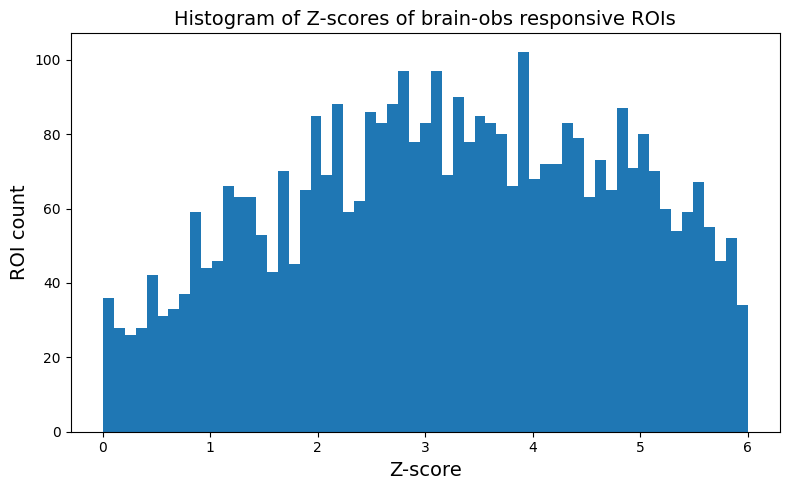

In [21]:
fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.hist(dg_full_metrics.z_score[dg_full_metrics.is_responsive], bins=np.linspace(0, 6, 60))
ax.set_xlabel("Z-score", fontsize=14)
ax.set_ylabel("ROI count", fontsize=14)
ax.set_title("Histogram of Z-scores of brain-obs responsive ROIs", fontsize=14)
fig.tight_layout()

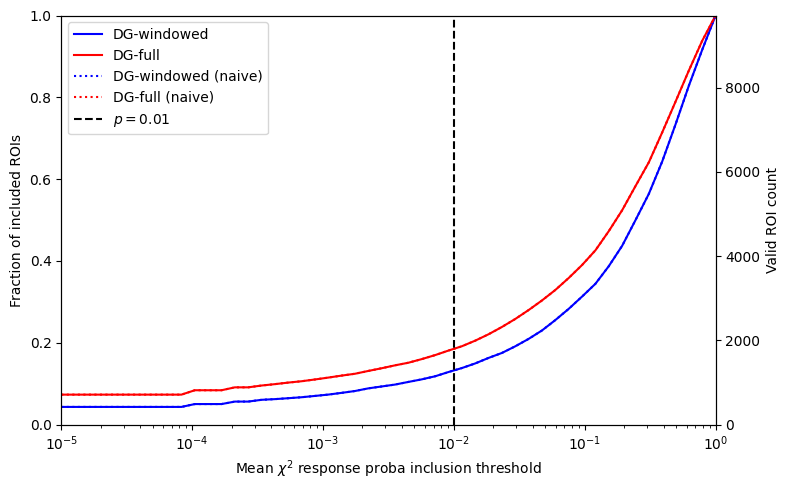

In [13]:
x = np.logspace(-5, 0, 50)
yf = [np.mean(dg_full_metrics.chisq_response_p < thresh) for thresh in x]
yw = [np.mean(dg_windowed_metrics.chisq_response_p < thresh) for thresh in x]
yfn = [np.mean(dg_full_metrics.chisq_response_p < thresh) for thresh in x]
ywn = [np.mean(dg_windowed_metrics.chisq_response_p < thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, yw, color="b", label="DG-windowed")
ax.plot(x, yf, color="r", label="DG-full")
ax.plot(x, ywn, color="b", linestyle="dotted", label="DG-windowed (naive)")
ax.plot(x, yfn, color="r", linestyle="dotted", label="DG-full (naive)")
ax.set_xlabel(r"Mean $\chi^2$ response proba inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax.axvline(x=0.01, color="black", linestyle="dashed", label="$p=0.01$")
ax.set_xscale("log")
ax2 = ax.twinx()
ax2.set_ylim(0, len(dg_full_metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/inclusion_frac_pref_chisq_resp_proba.png")

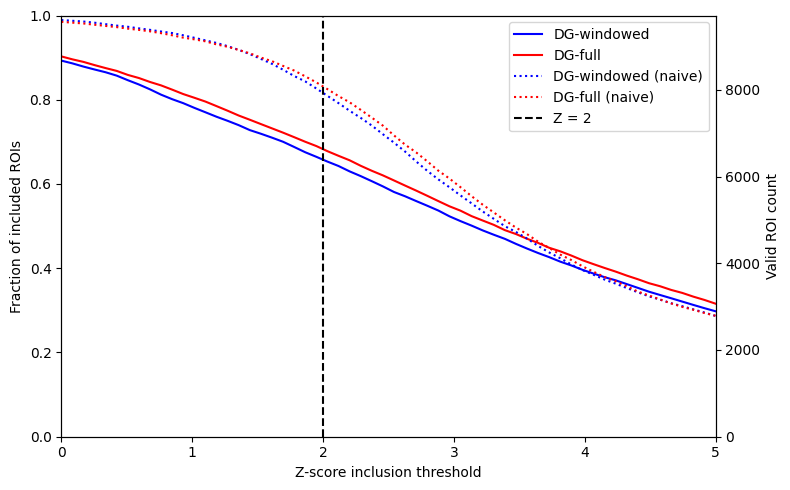

In [24]:
x = np.linspace(0, 5, 60)
yf = [np.mean(dg_full_metrics.z_score >= thresh) for thresh in x]
yw = [np.mean(dg_windowed_metrics.z_score >= thresh) for thresh in x]
yfn = [np.mean(dg_full_metrics.z_score_naive >= thresh) for thresh in x]
ywn = [np.mean(dg_windowed_metrics.z_score_naive >= thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, yw, color="b", label="DG-windowed")
ax.plot(x, yf, color="r", label="DG-full")
ax.plot(x, ywn, color="b", linestyle="dotted", label="DG-windowed (naive)")
ax.plot(x, yfn, color="r", linestyle="dotted", label="DG-full (naive)")
ax.axvline(x=2, color="black", linestyle="dashed", label="Z = 2")
ax.set_xlabel("Z-score inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax2 = ax.twinx()
ax2.set_ylim(0, len(dg_full_metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/inclusion_frac_z_score.png")

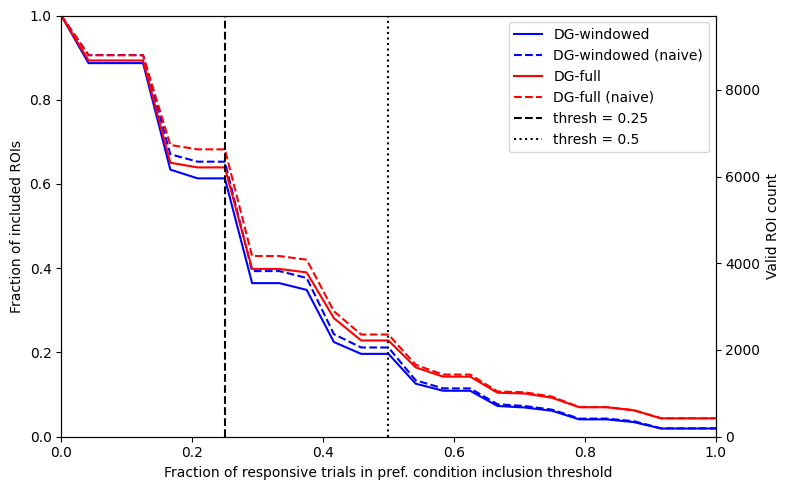

In [14]:
x = np.linspace(0, 1, 25)
yf = [np.mean(dg_full_metrics.frac_responsive_trials >= thresh) for thresh in x]
yfn = [np.mean(dg_full_metrics.frac_responsive_trials_naive >= thresh) for thresh in x]
yw = [np.mean(dg_windowed_metrics.frac_responsive_trials >= thresh) for thresh in x]
ywn = [np.mean(dg_windowed_metrics.frac_responsive_trials_naive >= thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, yw, color="b", label="DG-windowed")
ax.plot(x, ywn, color="b", linestyle="dashed", label="DG-windowed (naive)")
ax.plot(x, yf, color="r", label="DG-full")
ax.plot(x, yfn, color="r", linestyle="dashed", label="DG-full (naive)")
ax.set_xlabel("Fraction of responsive trials in pref. condition inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax.axvline(x=0.25, color="black", linestyle="dashed", label="thresh = 0.25")
ax.axvline(x=0.5, color="black", linestyle="dotted", label="thresh = 0.5")
ax2 = ax.twinx()
ax2.set_ylim(0, len(dg_full_metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/inclusion_frac_vis_coding.png")

## Plot example responses

In [11]:
def response_plot(index, plot="tuning", **kwargs):
    at.dg_response_plot(index, dg_full_metrics, dg_full, dg_windowed, plot=plot, **kwargs)

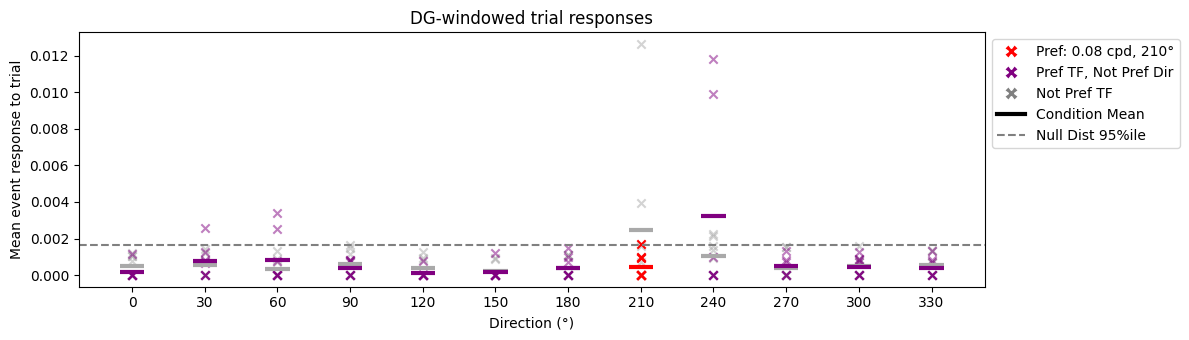

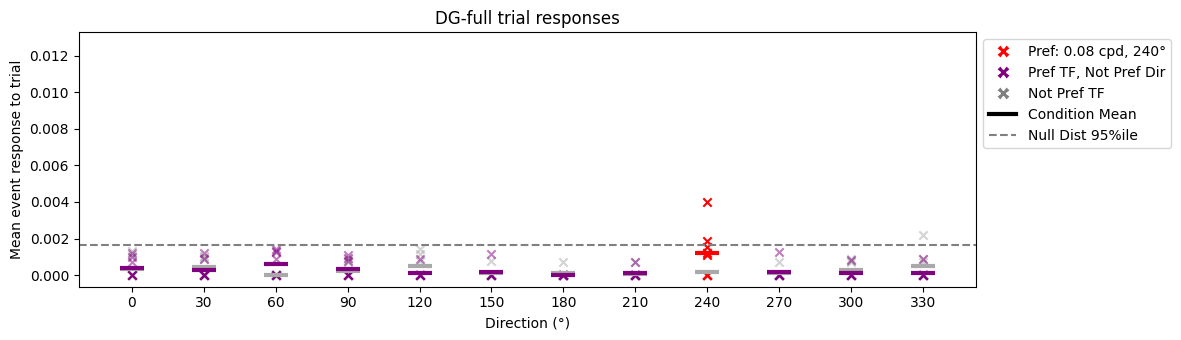

In [12]:
response_plot("M409828_13_1_46", plot="trial_response", response_type="raw")

## Compute surround suppression metrics

(-1.0738071024417877,
 1.0987527191638946,
 -1.0689263582229613,
 1.0985203027725219)

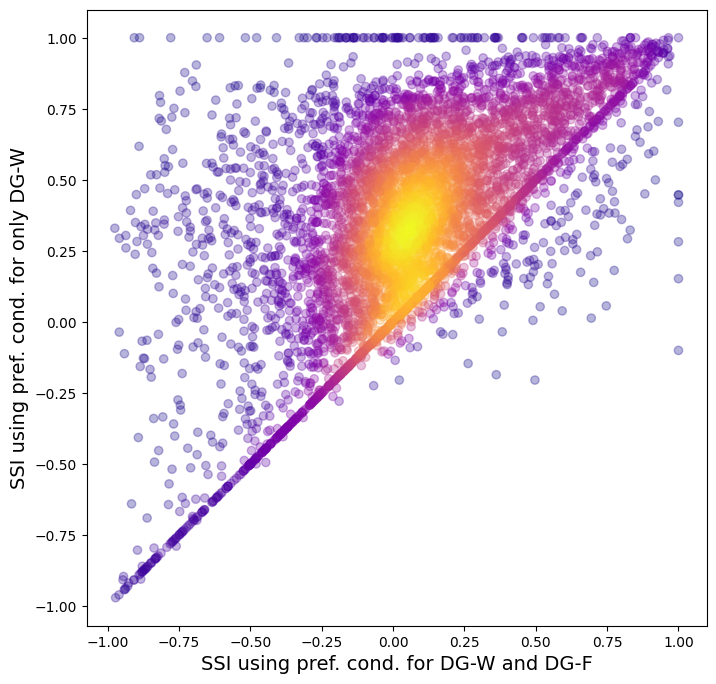

In [31]:
inclusion = dg_windowed_metrics.is_responsive
at.density_scatter(
    ss_metrics.ssi_pref_both[inclusion], ss_metrics.ssi[inclusion],
    figsize=(8, 8),
    xlabel="New SSI using pref. cond. for DG-W and DG-F",
    ylabel="Old SSI using pref. cond. for only DG-W",
    alpha=0.3
).axis("equal")

Text(0.5, 1.0, 'New SSI distribution of responsive-dgw & responsive-dgf')

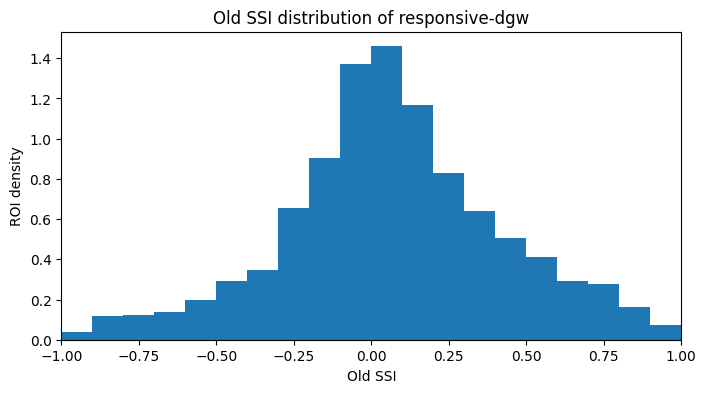

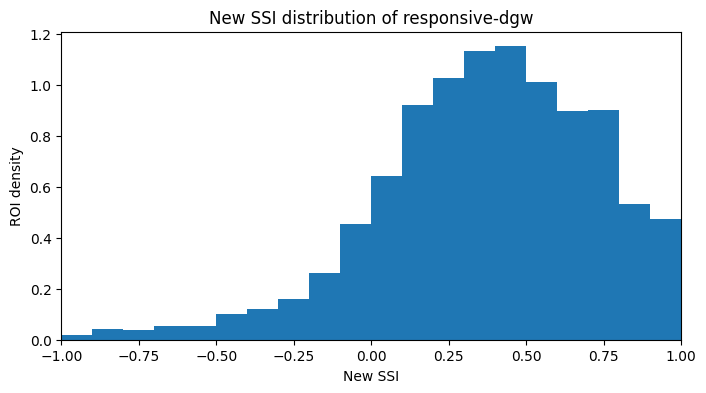

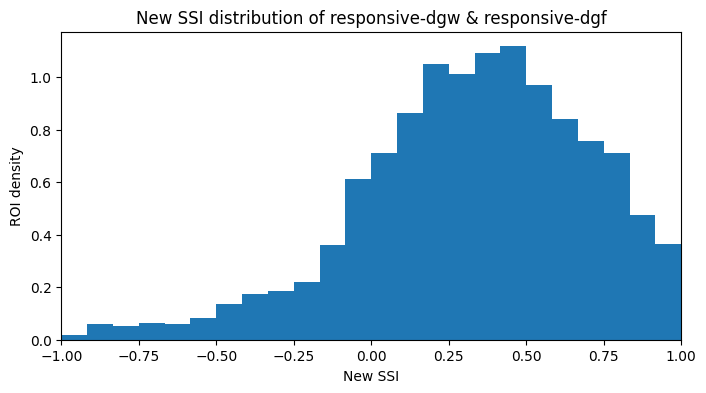

In [38]:
fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
ssi = ss_metrics.ssi_pref_both[dg_windowed_metrics.is_responsive]

ax.hist(ssi, bins=bins, density=True)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("Old SSI")
ax.set_ylabel("ROI density")
ax.set_title("Old SSI distribution of responsive-dgw")

fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
ssi = ss_metrics.ssi[dg_windowed_metrics.is_responsive]

ax.hist(ssi, bins=bins, density=True)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("New SSI")
ax.set_ylabel("ROI density")
ax.set_title("New SSI distribution of responsive-dgw")


fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 25)
ssi = ss_metrics.ssi[dg_windowed_metrics.is_responsive & dg_full_metrics.is_responsive]

ax.hist(ssi, bins=bins, density=True)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("New SSI")
ax.set_ylabel("ROI density")
ax.set_title("New SSI distribution of responsive-dgw & responsive-dgf")

In [42]:
ss_metrics[dg_windowed_metrics.is_responsive].head()

mouse  column volume  plane  roi  is_valid  depth  \
M409828_11_1_89   409828       1      1      1   89      True     50   
M409828_11_2_1    409828       1      1      2    1      True     66   
M409828_11_2_2    409828       1      1      2    2      True     66   
M409828_11_2_159  409828       1      1      2  159      True     66   
M409828_11_3_0    409828       1      1      3    0      True     82   

                    resp_w    resp_f  resp_w_pref_f  resp_f_pref_w       ssi  \
M409828_11_1_89   0.000575  0.000793       0.000854       0.000609 -0.028888   
M409828_11_2_1    0.008157  0.011217       0.002046       0.009295 -0.065169   
M409828_11_2_2    0.001224  0.001237       0.000344       0.000369  0.536319   
M409828_11_2_159  0.001702  0.001271       0.000991       0.000599  0.479005   
M409828_11_3_0    0.024129  0.041528       0.004126       0.032169 -0.142808   

                  si_cavanaugh_2002  ssi_pref_both  
M409828_11_1_89           -0.059494      -0.159389  
M409828_11_2_1            -0.139425      -0.157938  
M409828_11_2_2             0.698187      -0.005231  
M409828_11_2_159           0.647739       0.144971  
M409828_11_3_0            -0.333199      -0.264986

In [148]:
is_responsive = dg_windowed_metrics.frac_responsive_trials_naive >= 0.25
np.count_nonzero(is_responsive & (ss_metrics.resp_w > 1.5e-3)) / np.count_nonzero(is_responsive)

0.6328297135662575

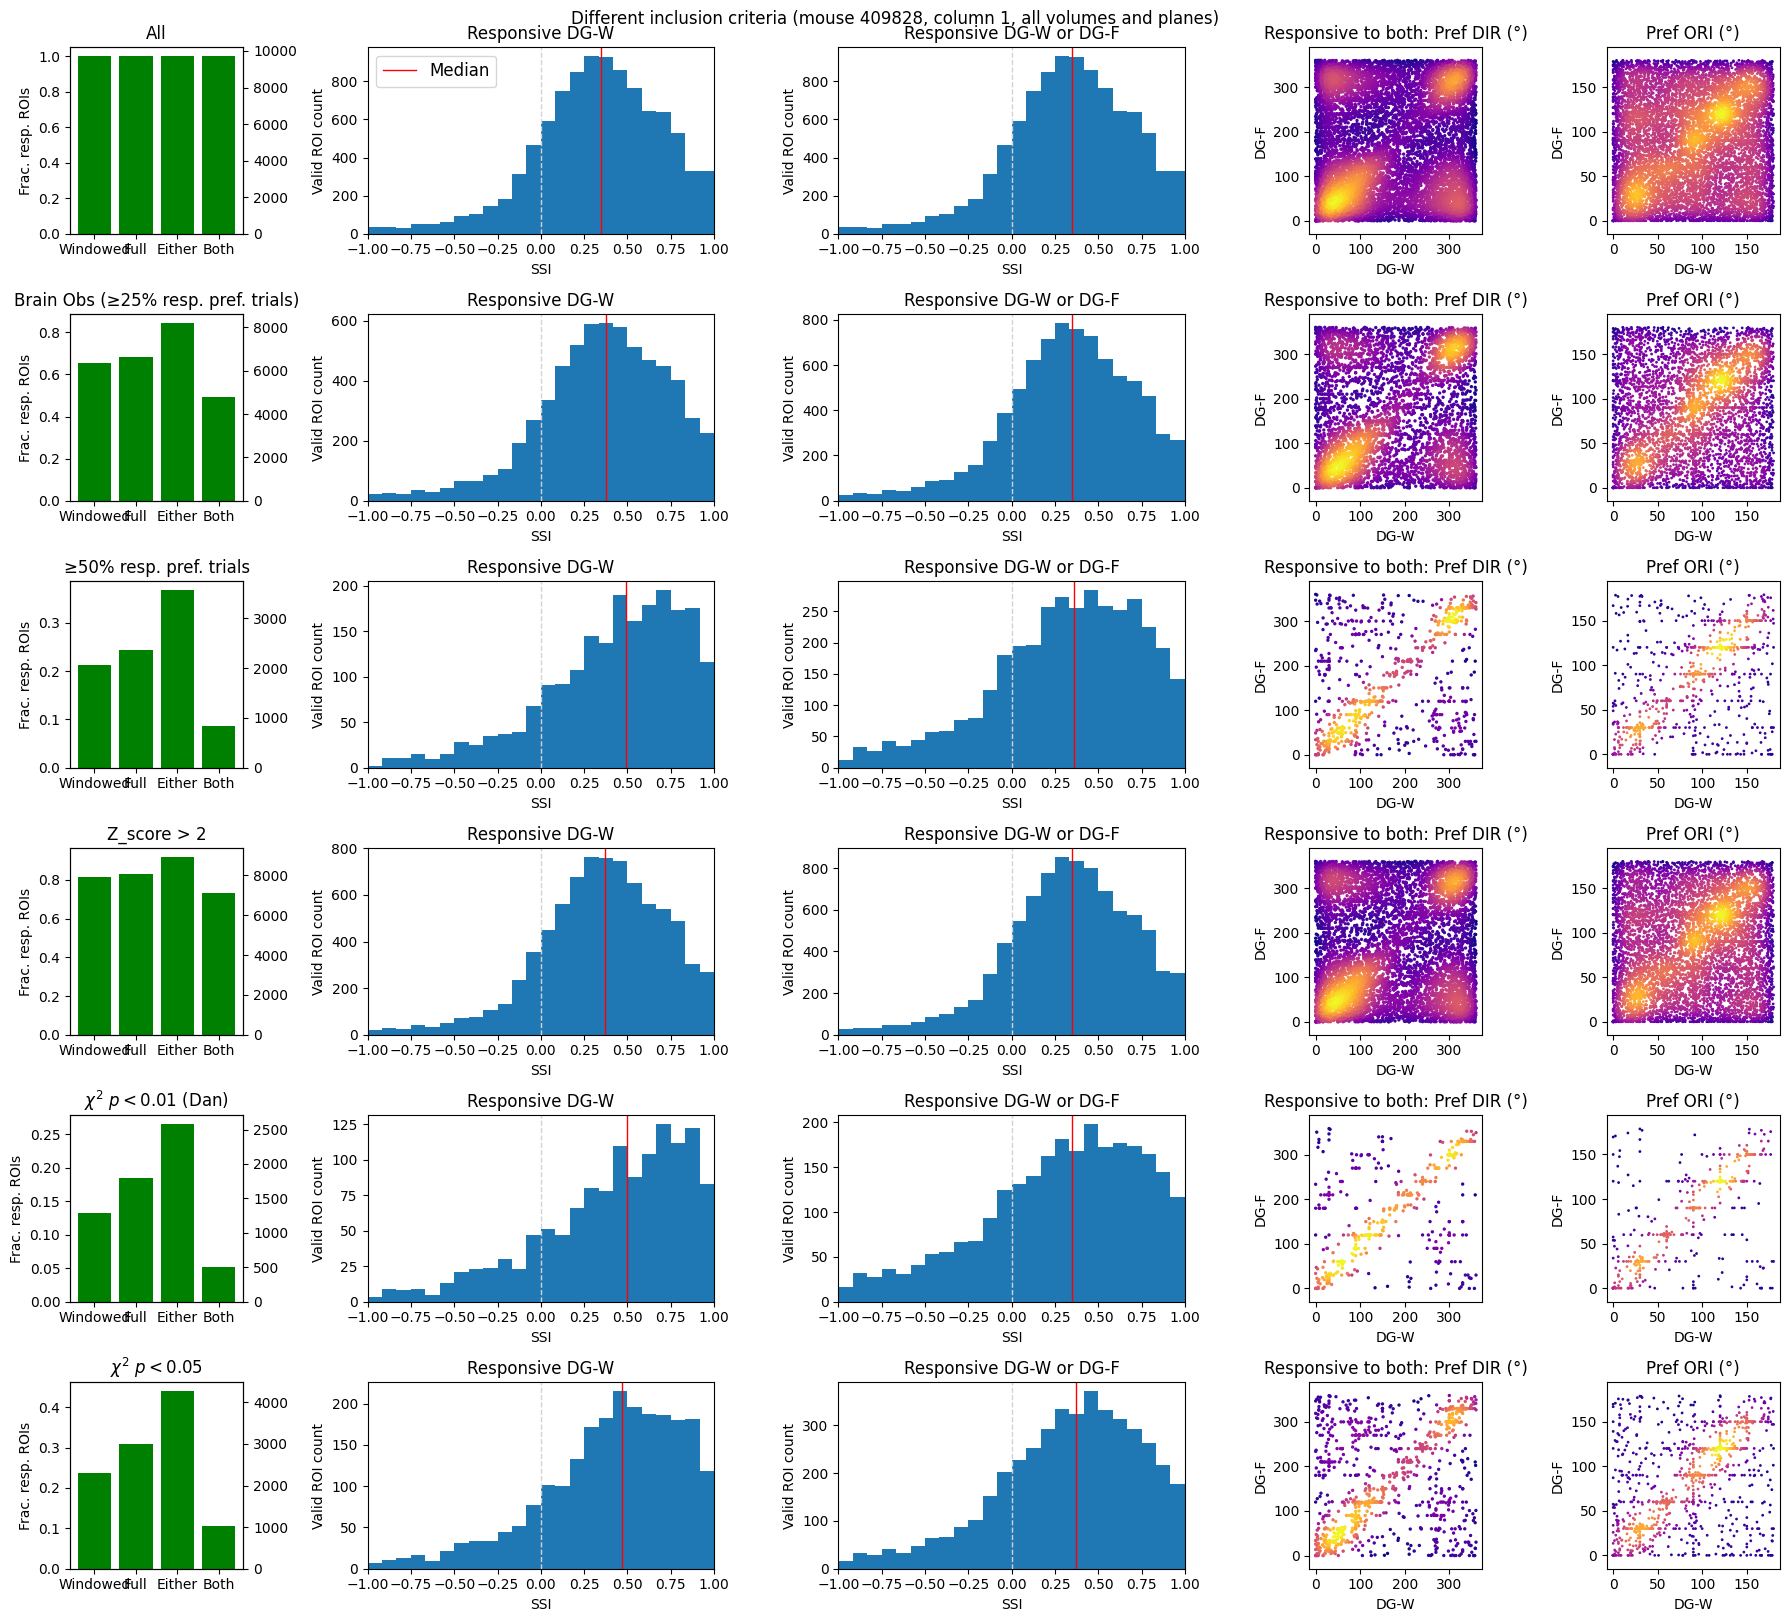

In [41]:
inclusion_criteria = [
    (lambda df: df.index == df.index, r"All"),
    (lambda df: df.frac_responsive_trials_naive >= 0.25, r"Brain Obs (≥25% resp. pref. trials)"),
    (lambda df: df.frac_responsive_trials_naive >= 0.5, r"≥50% resp. pref. trials"),
    # (lambda df: df.frac_responsive_trials_naive >= 0.35, r"≥35% resp trials in pref dir"),
    (lambda df: df.z_score_naive > 2, r"Z_score > 2"),
    (lambda df: df.chisq_response_p < 0.01, r"$\chi^2$ $p < 0.01$ (Dan)"),
    (lambda df: df.chisq_response_p < 0.05, r"$\chi^2$ $p < 0.05$"),
    # (lambda df, resp: (df.frac_responsive_trials_naive >= 0.25) & (resp > 1.5e-3), r"Brain Obs & R > 1e-3"),
    # (lambda df: df.z_score_naive > 3, r"Z_score > 3"),
    # (lambda df: df.z_score > 3.5, r"Z_score > 3.5"),
    # (lambda df: df.z_score_naive > 4, r"Z_score > 4"),
    # (lambda df: df.z_score_naive > 5, r"Z_score > 5"),
    # (lambda df: df.z_score_naive > 3, r"Z_score_naive > 3"),
    # (lambda df: df.response_p_naive < 0.05, r"pref_resp_proba < 0.05"),
    # (lambda df: df.response_p_naive < 0.05, r"pref_resp_proba_naive < 0.05"),
    # (lambda df: df.response_p_naive < 0.05/24, r"pref_resp_proba < 0.05/24"),
    # (lambda df: df.response_p_naive == 0, r"pref_resp_proba == 0"),
    # (lambda df: df.z_score > 3, r"Z_score > 3"),
]

fig, ax_rows = plt.subplots(figsize=(18, len(inclusion_criteria)*2.75), nrows=len(inclusion_criteria), ncols=5, gridspec_kw=dict(width_ratios=[1, 2, 2, 1, 1]))
ss_bins = np.linspace(-1, 1, 25)

for i, axs in enumerate(ax_rows):
    inclusion, name = inclusion_criteria[i]
    include_mask = inclusion(dg_windowed_metrics) if inclusion.__code__.co_argcount == 1 else inclusion(dg_windowed_metrics, ss_metrics["resp_w"])
    mask_full = inclusion(dg_full_metrics) if inclusion.__code__.co_argcount == 1 else inclusion(dg_full_metrics, ss_metrics["resp_f"])
    tot = len(dg_windowed_metrics)

    ax = axs[0]
    ax.set_title(f"{name}")
    ax.bar(
        x=["Windowed", "Full", "Either", "Both"],
        height=[np.mean(include_mask), np.mean(mask_full), np.mean(include_mask | mask_full), np.mean(include_mask & mask_full)],
        color="g")
    ax.set_ylabel("Frac. resp. ROIs")
    # ax.set_ylim(0, 1)
    ax.twinx().set_ylim(0, ax.get_ylim()[1]*tot)
    
    ax = axs[1]
    ax.hist(ss_metrics.ssi[include_mask], bins=ss_bins)
    ax.axvline(x=0, color="lightgray", linestyle="dashed", linewidth=1)
    ax.axvline(x=np.median(ss_metrics.ssi[include_mask]), color="red", linestyle="solid", linewidth=1, label="Median")
    ax.set_xlim(-1, 1)
    ax.set_xlabel("SSI")
    ax.set_ylabel("Valid ROI count")
    ax.set_title("Responsive DG-W")

    if i == 0:
        ax.legend(loc="upper left", fontsize=12)

    ax = axs[2]
    ax.hist(ss_metrics.ssi[include_mask | mask_full], bins=ss_bins)
    ax.axvline(x=0, color="lightgray", linestyle="dashed", linewidth=1)
    ax.axvline(x=np.median(ss_metrics.ssi[include_mask | mask_full]), color="red", linestyle="solid", linewidth=1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel("SSI")
    ax.set_ylabel("Valid ROI count")
    ax.set_title("Responsive DG-W or DG-F")

    ax = axs[3]
    both = include_mask & mask_full
    at.density_scatter(dg_windowed_metrics.pref_dir_mean[both], dg_full_metrics.pref_dir_mean[both], ax=ax, s=2)
    # ticks = dg_full[0].dir_list
    # ax.set_xticks(ticks)
    # ax.set_yticks(ticks)
    ax.set_title("Responsive to both: Pref DIR (°)")
    ax.set_xlabel("DG-W")
    ax.set_ylabel("DG-F")
    ax.axis("equal")

    ax = axs[4]
    at.density_scatter(np.mod(dg_windowed_metrics.pref_dir_mean[both], 180), np.mod(dg_full_metrics.pref_dir_mean[both], 180), ax=ax, s=1)
    ax.set_title("Pref ORI (°)")
    ax.set_xlabel("DG-W")
    ax.set_ylabel("DG-F")
    ax.axis("equal")
    # ax.set_xlim(0, 180)
    # ax.set_ylim(0, 180)

fig.suptitle(f"Different inclusion criteria (mouse {mouse}, column {column}, all volumes and planes)")
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/ssi_inclusion.png")

In [42]:
dg_full_metrics.columns

Index(['mouse', 'column', 'volume', 'plane', 'roi', 'depth', 'is_valid',
       'is_responsive', 'pref_dir', 'pref_sf', 'pref_dir_idx', 'pref_sf_idx',
       'pref_dir_mean', 'pref_sf_mean', 'osi', 'dsi', 'pref_dir_naive',
       'pref_sf_naive', 'pref_dir_naive_idx', 'pref_sf_naive_idx', 'z_score',
       'z_score_naive', 'response_p', 'response_p_naive', 'gosi_naive',
       'dsi_naive', 'osi_notcrossval', 'osi_naive', 'frac_responsive_trials',
       'frac_responsive_trials_naive', 'is_responsive_naive',
       'lifetime_sparseness', 'p_trial_responses', 'sig_trial_responses',
       'pref_ori', 'pref_ori_naive', 'chisq_response_p', 'depth_chunk',
       'vol_plane'],
      dtype='object')

In [19]:
def f_depth_chunk(row):
    depth_chunk = int(np.floor((row.depth - 50) / 48)) # 50 is shallowest depth; 48 is size of chunk
    if depth_chunk > 10:
        depth_chunk = 10 # deeper chunks to go 10
    return depth_chunk

for df in (dg_full_metrics, dg_windowed_metrics, ss_metrics):
    df["depth_chunk"] = df.apply(f_depth_chunk, axis=1)
    df["vol_plane"] = df.apply(lambda row: f"{row.volume}-{row.plane}", axis=1)

ss_metrics["depth_chunk"].value_counts()

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_39781/3379400680.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["depth_chunk"] = df.apply(f_depth_chunk, axis=1)
/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_39781/3379400680.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vol_plane"] = df.apply(lambda row: f"{row.volume}-{row.plane}", axis=1)


4     1362
5     1346
6     1307
3     1081
2      985
10     924
7      910
8      623
9      589
1      551
0       36
Name: depth_chunk, dtype: int64

### Define an inlcusion criteria

In [20]:
inclusion = (dg_windowed_metrics.frac_responsive_trials_naive >= 0.5)# & (ss_metrics.resp_w > 1e-5) # & ~dg_windowed_metrics.isna().any(axis=1) & ~dg_full_metrics.isna().any(axis=1)
print(np.mean(inclusion)*100, "% ROIs included")


21.18591723285979 % ROIs included


(array([  3.,   1.,   3.,   6.,  18.,  20.,  55., 107., 207., 296., 320.,
        203., 145., 108., 116., 114., 141., 116.,  63.,  16.]),
 array([0.32673974399981287, 0.35867822536750366, 0.39061670673519444,
        0.4225551881028853, 0.45449366947057607, 0.48643215083826685,
        0.5183706322059577, 0.5503091135736484, 0.5822475949413393,
        0.6141860763090301, 0.6461245576767208, 0.6780630390444117,
        0.7100015204121024, 0.7419400017797932, 0.7738784831474841,
        0.8058169645151749, 0.8377554458828657, 0.8696939272505565,
        0.9016324086182472, 0.9335708899859381, 0.9655093713536289],
       dtype=object),
 <BarContainer object of 20 artists>)

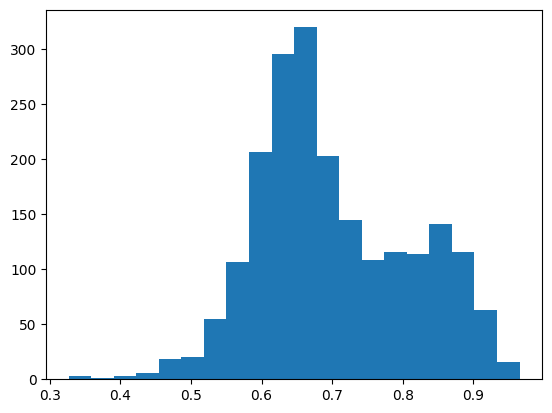

In [21]:
plt.hist(dg_windowed_metrics.lifetime_sparseness[inclusion], bins=20)

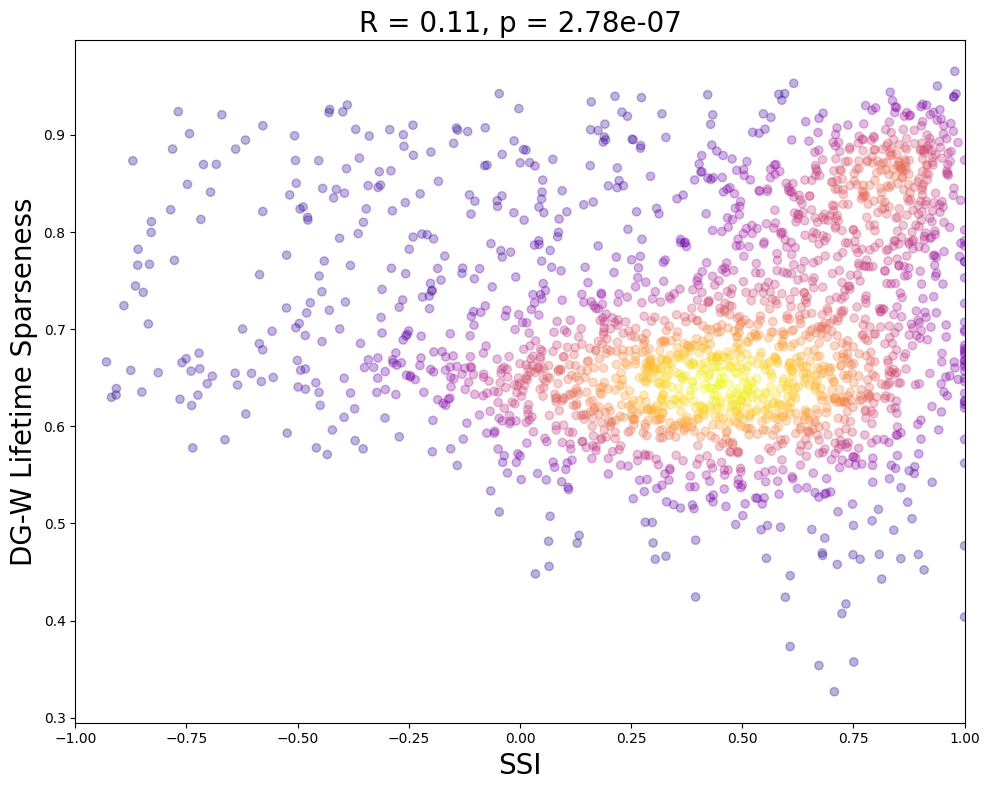

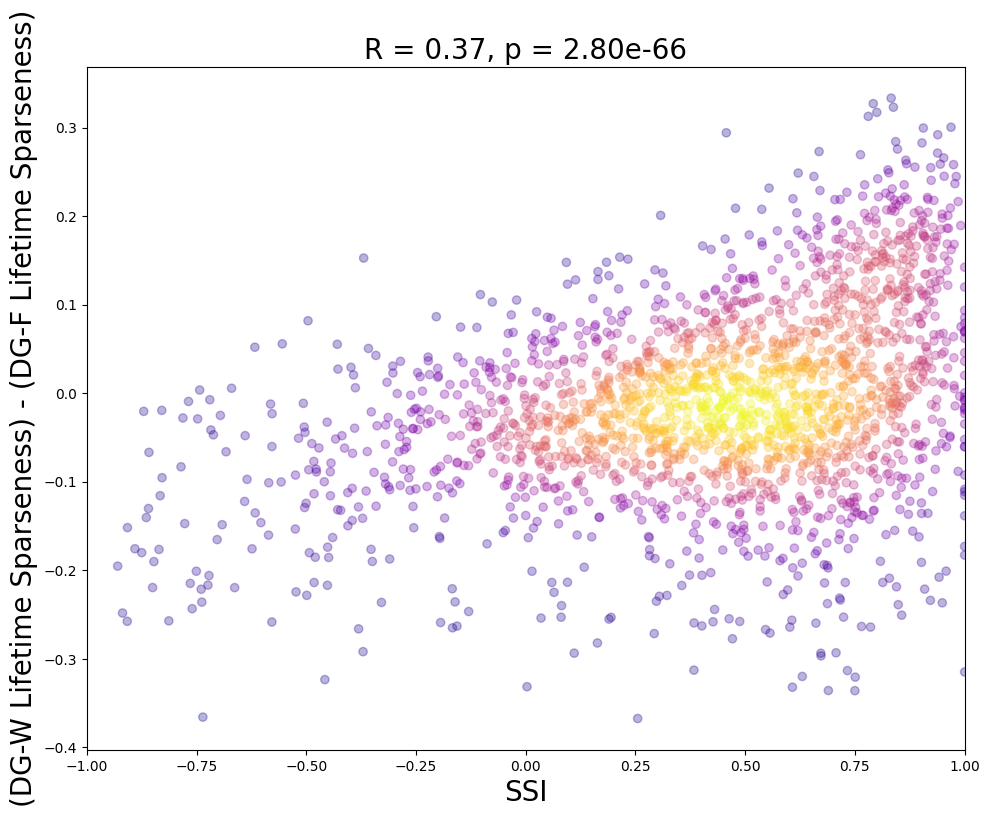

In [22]:
x, y = ss_metrics.ssi[inclusion], dg_windowed_metrics.lifetime_sparseness[inclusion]
r, p = st.pearsonr(x, y)
ax = at.density_scatter(x, y, figsize=(10, 8), alpha=0.3, marker="o", xlabel="SSI", ylabel="DG-W Lifetime Sparseness", title=f"R = {r:.2f}, p = {p:.2e}", labelfontsize=20, titlefontsize=20)
fig = ax.get_figure()
ax.set_xlim(-1, 1)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/dgw_sparseness_ssi.png")

x, y = ss_metrics.ssi[inclusion], dg_windowed_metrics.lifetime_sparseness[inclusion] - dg_full_metrics.lifetime_sparseness[inclusion]
r, p = st.pearsonr(x, y)
ax = at.density_scatter(x, y, figsize=(10, 8), alpha=0.3, marker="o", xlabel="SSI", title=f"R = {r:.2f}, p = {p:.2e}", ylabel="(DG-W Lifetime Sparseness) - (DG-F Lifetime Sparseness)", labelfontsize=20, titlefontsize=20)
fig = ax.get_figure()
ax.set_xlim(-1, 1)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/dgw_dgf_sparseness_ssi.png")

(0.005035388268478873,
 0.9322924844731248,
 0.03816352241103747,
 1.0096293311582845)

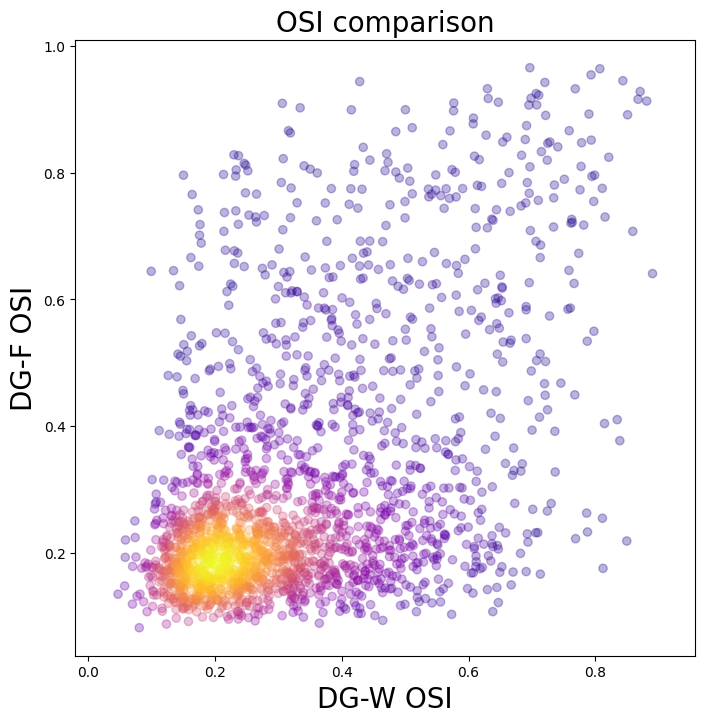

In [23]:
x, y = dg_windowed_metrics.osi[inclusion], dg_full_metrics.osi[inclusion]
ax = at.density_scatter(x, y, figsize=(8, 8), alpha=0.3, marker="o", xlabel="DG-W OSI", ylabel="DG-F OSI", title=f"OSI comparison", labelfontsize=20, titlefontsize=20)
ax.axis("equal")

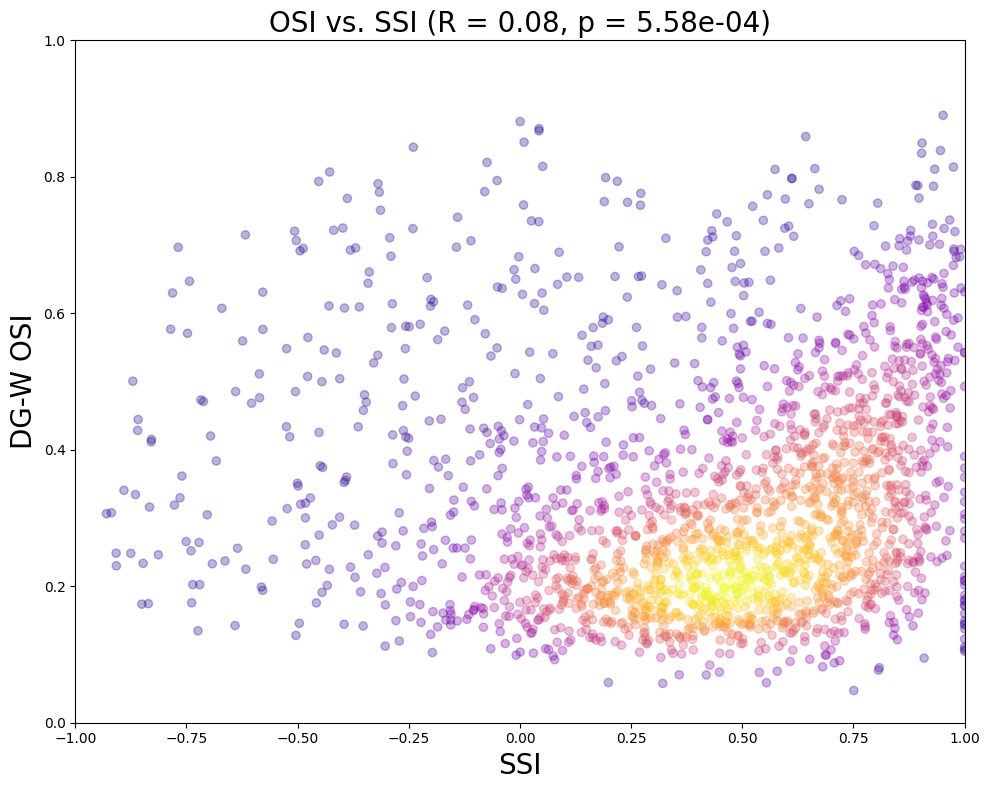

In [24]:
x, y = ss_metrics.ssi[inclusion], dg_windowed_metrics.osi[inclusion]
r, p = st.pearsonr(x, y)
ax = at.density_scatter(x, y, figsize=(10, 8), alpha=0.3, marker="o", xlabel="SSI", ylabel="DG-W OSI", title=f"OSI vs. SSI (R = {r:.2f}, p = {p:.2e})", labelfontsize=20, titlefontsize=20)
fig = ax.get_figure()
ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/osi_vs_ssi.png")


In [25]:
dg_full_metrics["lifetime_sparseness"] = dg_full_metrics["lifetime_sparseness"].astype(float)
dg_windowed_metrics["lifetime_sparseness"] = dg_windowed_metrics["lifetime_sparseness"].astype(float)

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_39781/3967341104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg_full_metrics["lifetime_sparseness"] = dg_full_metrics["lifetime_sparseness"].astype(float)


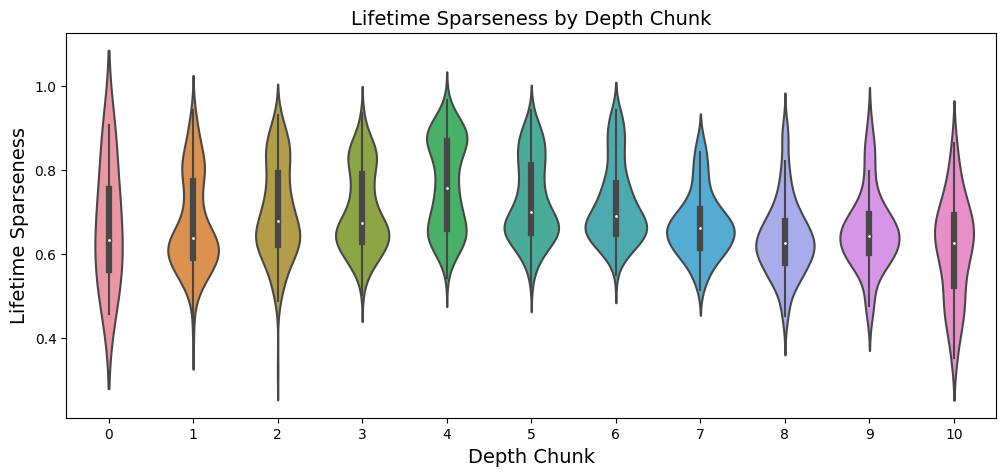

In [26]:
# Sparseness by depth
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")
sns.violinplot(data=dg_windowed_metrics[inclusion], x="depth_chunk", y="lifetime_sparseness")
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("Lifetime Sparseness", fontsize=14)
ax.set_title("Lifetime Sparseness by Depth Chunk", fontsize=14)
fig.savefig(f"{FIG_DIR}/sparseness_by_depth.png")

In [27]:
def vol_to_key(vol):
    if type(vol) is int and 1 <= vol <= 5:
        return f"Vol. {vol}"
    else:
        return "3P"

vol_key_to_color = {
    "Vol. 1": "red",
    "Vol. 2": "orange",
    "Vol. 3": "green",
    "Vol. 4": "blue",
    "Vol. 5": "purple",
    "3P": "pink"
}

legend_handles = [
    mpl.patches.Patch(facecolor=color, label=key)
    for key, color in vol_key_to_color.items()
]

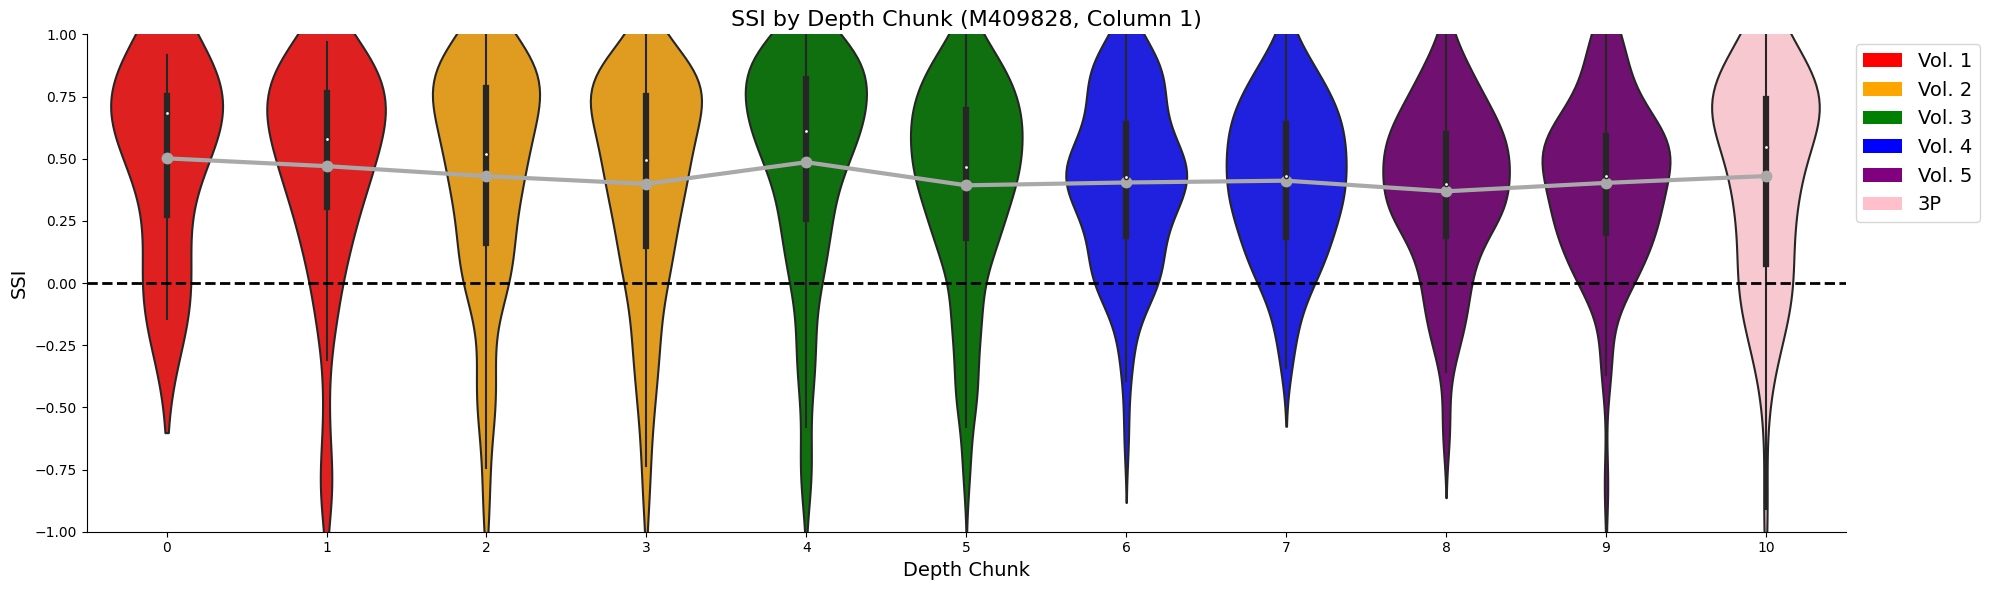

In [28]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth_chunk == d].iloc[0].volume) for d in ss_metrics[inclusion].depth_chunk.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.violinplot(data=ss_metrics[inclusion], x="depth_chunk", y="ssi", ax=ax, palette=colors)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-1, 1)
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("SSI", fontsize=14)
ax.set_title("SSI by Depth Chunk (M409828, Column 1)", fontsize=16)
means = ss_metrics[inclusion].groupby("depth_chunk").ssi.mean()
ax.plot(means.index, means.values, color="darkgray", linewidth=3, marker=".", markersize=15)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/ssi_by_depth_chunk.png")

['Vol. 1', 'Vol. 1', 'Vol. 1', 'Vol. 1', 'Vol. 1', 'Vol. 2', 'Vol. 2', 'Vol. 2', 'Vol. 2', 'Vol. 2', 'Vol. 2', 'Vol. 3', 'Vol. 3', 'Vol. 3', 'Vol. 3', 'Vol. 3', 'Vol. 3', 'Vol. 4', 'Vol. 4', 'Vol. 4', 'Vol. 4', 'Vol. 4', 'Vol. 4', 'Vol. 5', 'Vol. 5', 'Vol. 5', 'Vol. 5', 'Vol. 5', 'Vol. 5', '3P', '3P', '3P', '3P', '3P', '3P', '3P', '3P', '3P', '3P']
['red', 'red', 'red', 'red', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'green', 'green', 'green', 'green', 'green', 'green', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink', 'pink']


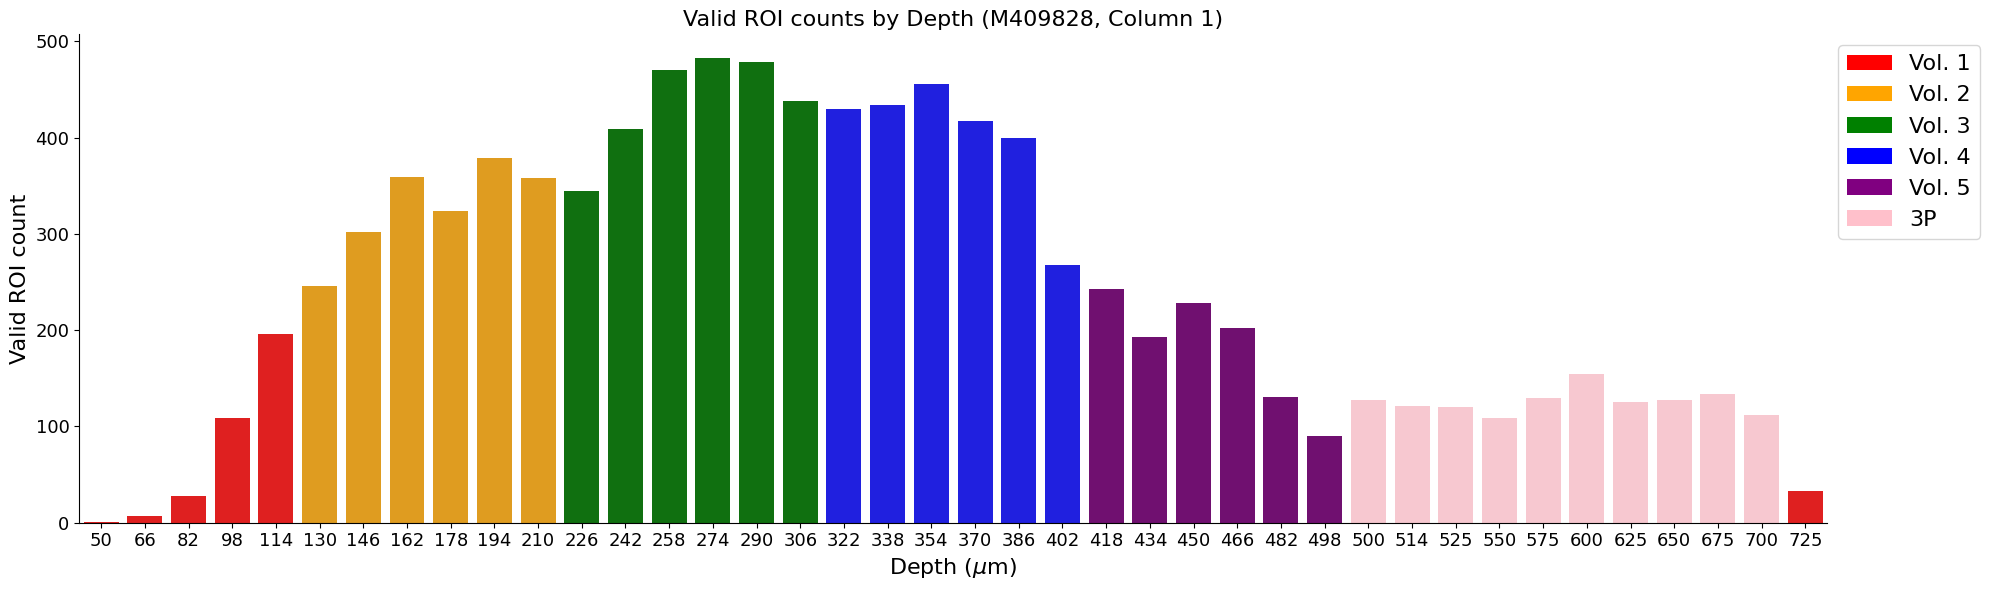

In [29]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth == d].iloc[0].volume) for d in ss_metrics[inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]
print(volume_keys)
print(colors)
sns.countplot(x=dg_full_metrics.depth, palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.tick_params(labelsize=13)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("Valid ROI count", fontsize=16)
ax.set_title("Valid ROI counts by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/roi_count_by_depth.png")

In [30]:
dg_windowed_metrics.is_responsive_naive

M409828_11_1_89     True
M409828_11_2_0     False
M409828_11_2_1      True
M409828_11_2_2      True
M409828_11_2_4     False
                   ...  
M409828_1f_1_67    False
M409828_1f_1_69     True
M409828_1f_1_70    False
M409828_1f_1_74     True
M409828_1f_1_90     True
Name: is_responsive_naive, Length: 9714, dtype: boolean

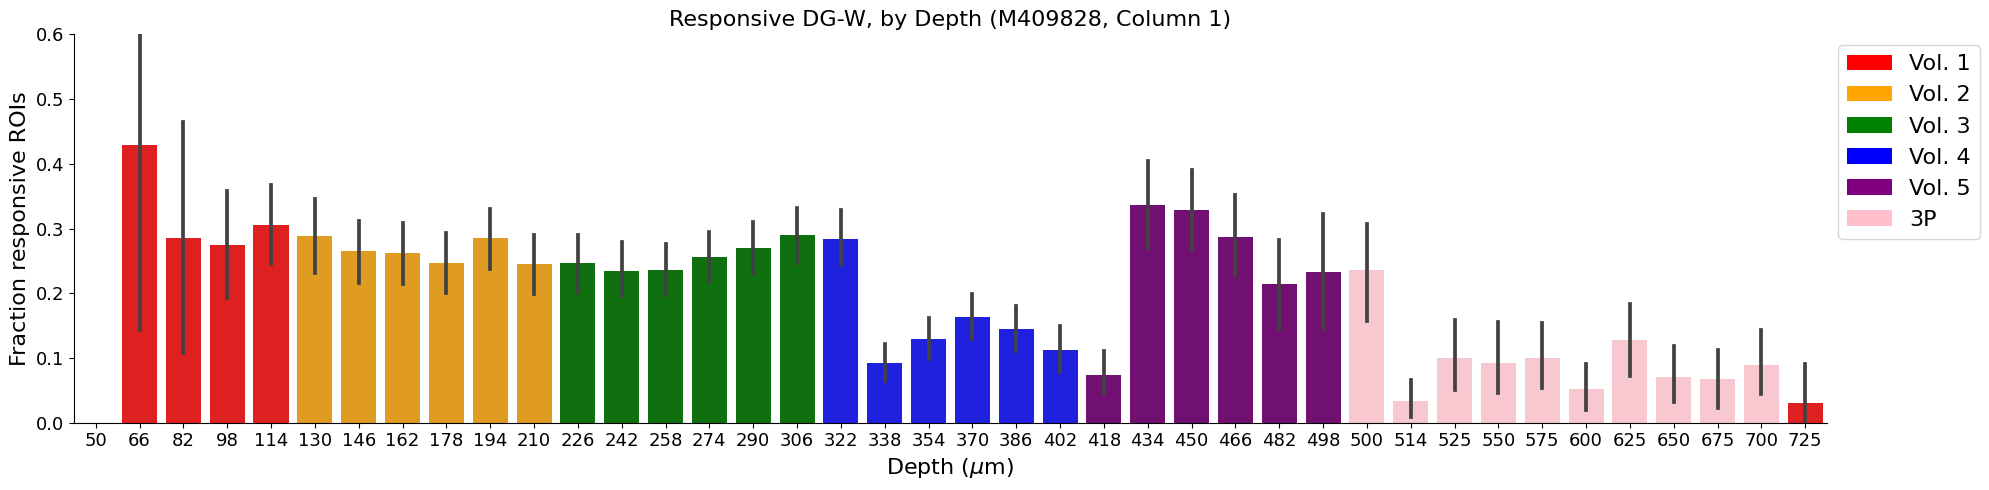

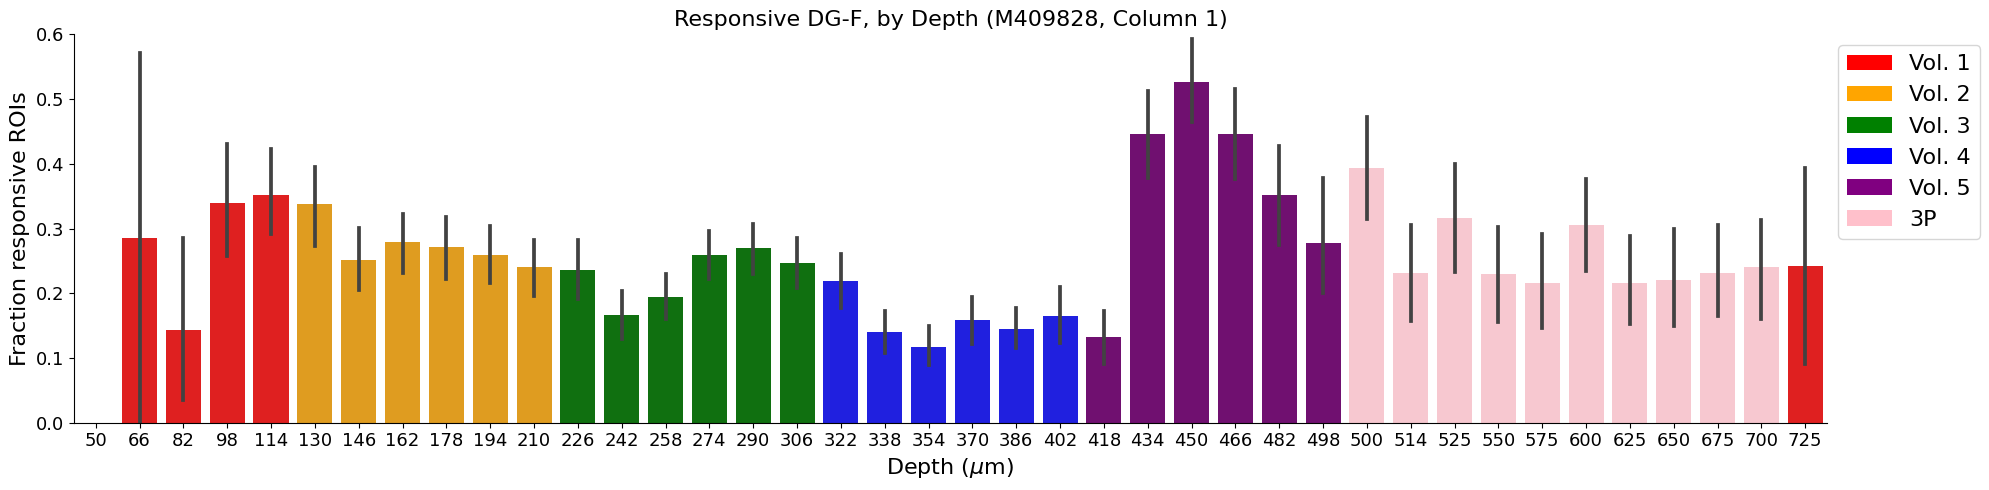

In [35]:
fig, ax = plt.subplots(figsize=(20, 5), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth == d].iloc[0].volume) for d in ss_metrics[inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

# sns.barplot(x=dg_full_metrics.depth, y=((dg_windowed_metrics.frac_responsive_trials_naive >= 0.25) | (dg_full_metrics.frac_responsive_trials_naive >= 0.25)), palette=colors, ax=ax)
sns.barplot(x=dg_full_metrics.depth, y=((dg_windowed_metrics.frac_responsive_trials_naive >= 0.5)), palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.set_ylim(0, 0.6)
ax.tick_params(labelsize=13)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("Fraction responsive ROIs", fontsize=16)
ax.set_title("Responsive DG-W, by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(20, 5), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth == d].iloc[0].volume) for d in ss_metrics[inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

# sns.barplot(x=dg_full_metrics.depth, y=((dg_windowed_metrics.frac_responsive_trials_naive >= 0.25) | (dg_full_metrics.frac_responsive_trials_naive >= 0.25)), palette=colors, ax=ax)
sns.barplot(x=dg_full_metrics.depth, y=((dg_full_metrics.frac_responsive_trials_naive >= 0.5)), palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.set_ylim(0, 0.6)
ax.tick_params(labelsize=13)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("Fraction responsive ROIs", fontsize=16)
ax.set_title("Responsive DG-F, by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/responsive_dg_by_depth.png")

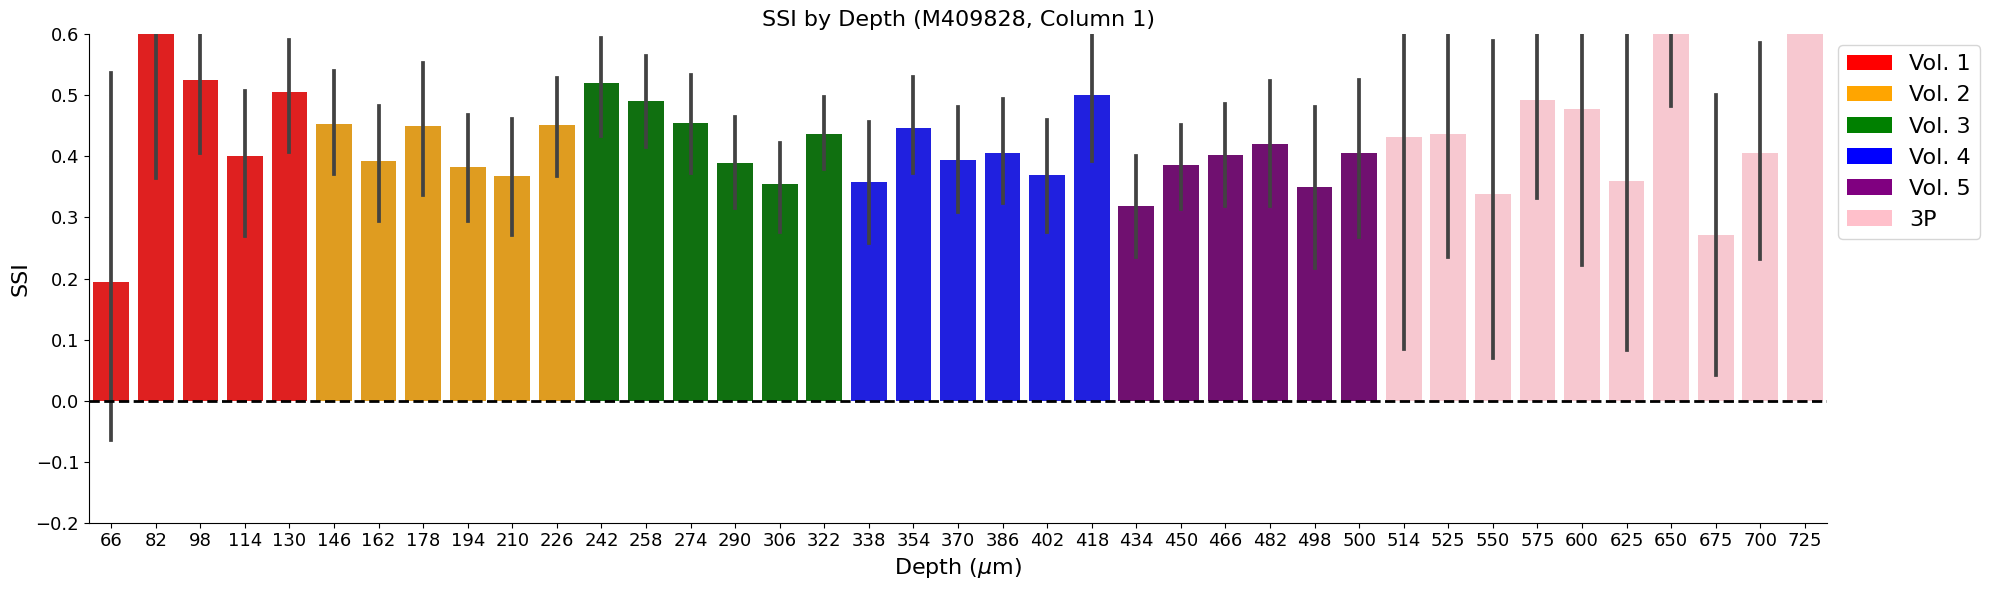

In [39]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth == d].iloc[0].volume) for d in ss_metrics[inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.barplot(data=ss_metrics[inclusion], x="depth", y="ssi", palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.set_ylim(-0.2, 0.6)
ax.tick_params(labelsize=13)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("SSI", fontsize=16)
ax.set_title("SSI by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/ssi_mean_by_depth.png")

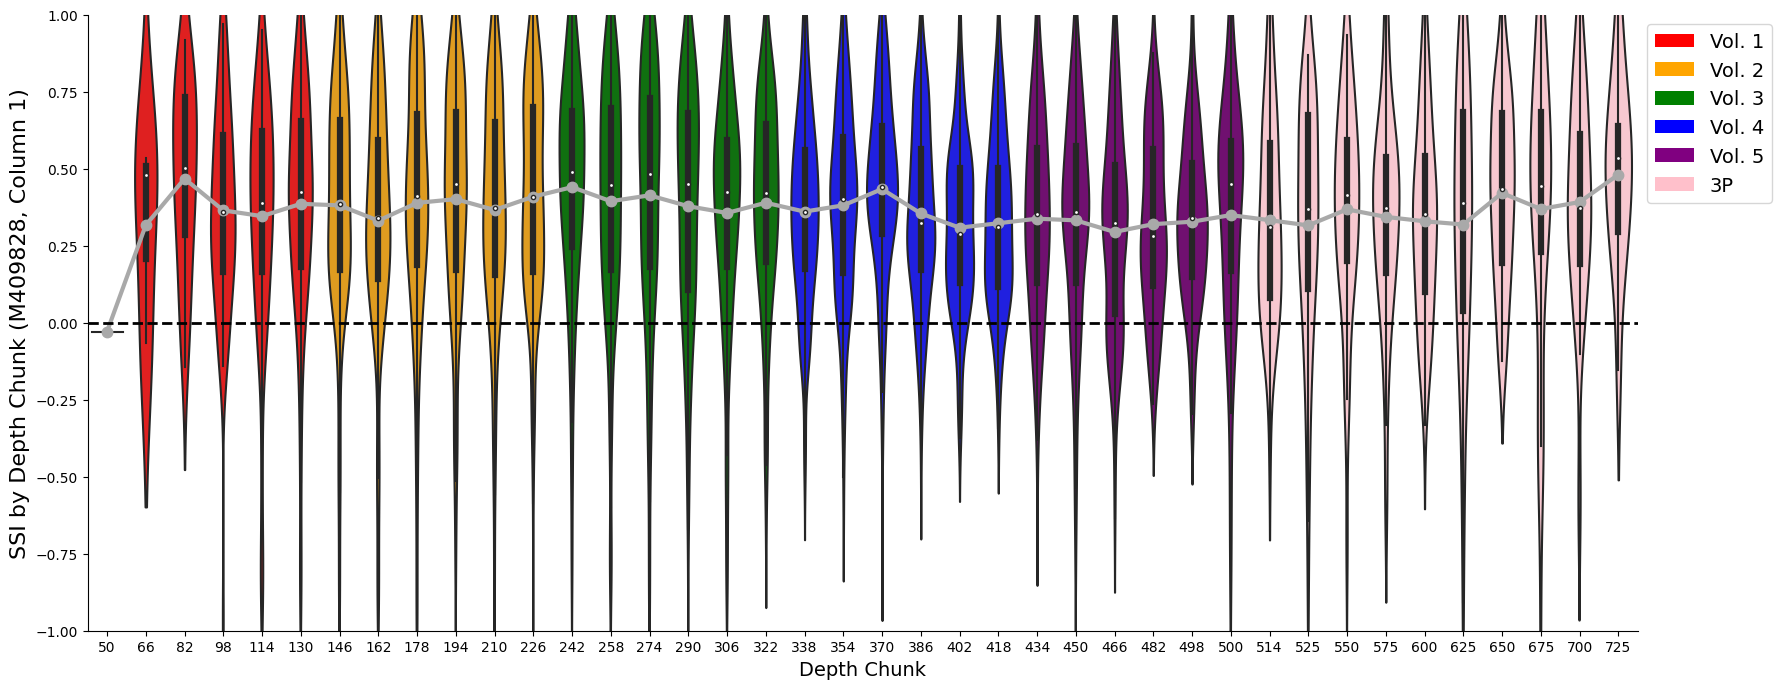

In [88]:
fig, ax = plt.subplots(figsize=(20, 8), facecolor="white")

sns.violinplot(data=ss_metrics[inclusion], x="depth", y="ssi", ax=ax, palette=colors)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
ax.set_ylim(-1, 1)
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("SSI", fontsize=14)
ax.set_ylabel("SSI by Depth Chunk (M409828, Column 1)", fontsize=16)
means = ss_metrics[inclusion].groupby("depth").ssi.mean()
ax.plot(range(len(means.index)), means.values, color="darkgray", linewidth=3, marker=".", markersize=15)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.set_xlim(-0.5, len(means)-0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

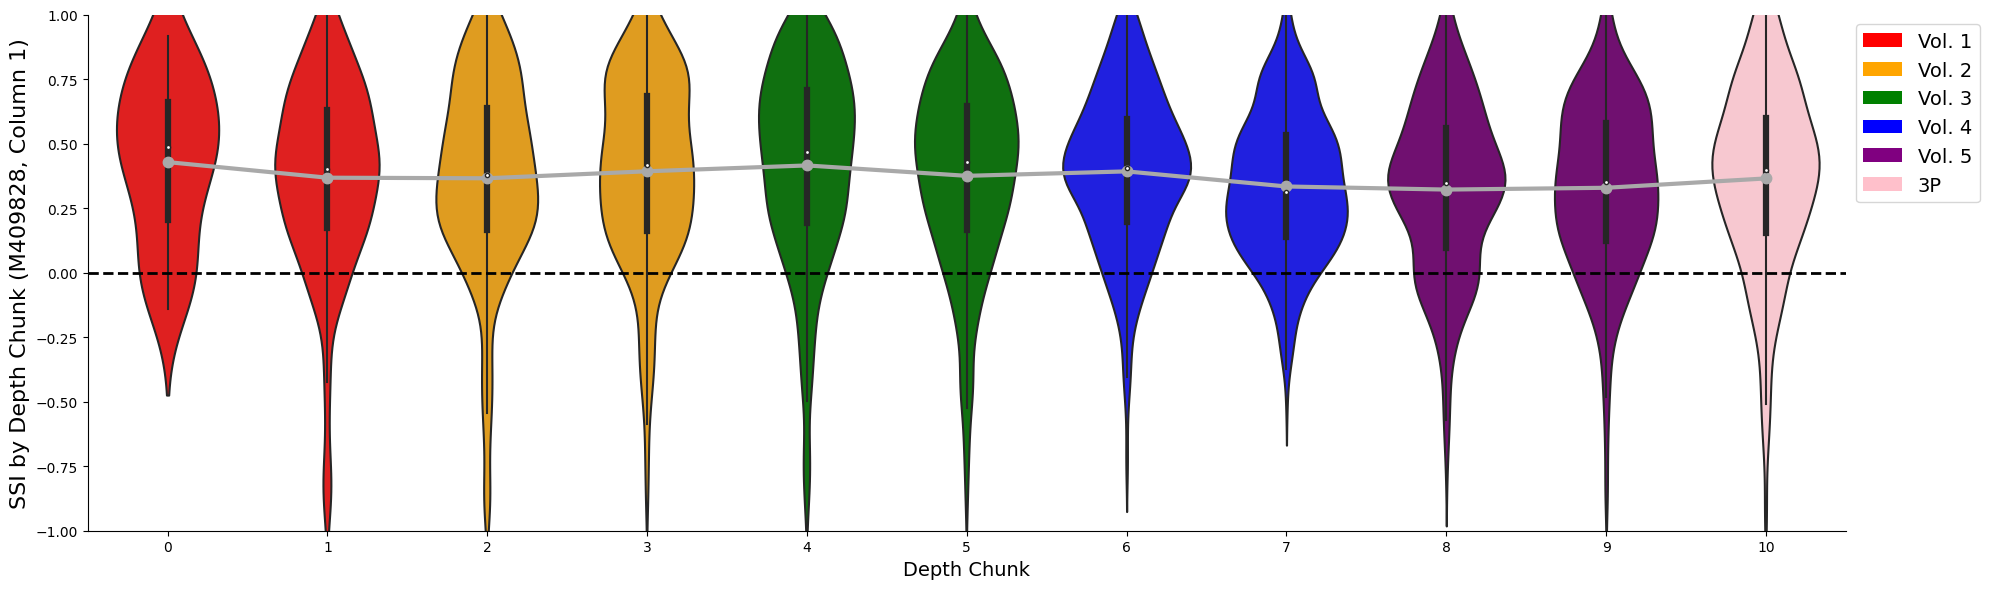

In [89]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth_chunk == d].iloc[0].volume) for d in ss_metrics[inclusion].depth_chunk.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.violinplot(data=ss_metrics[inclusion], x="depth_chunk", y="ssi", ax=ax, palette=colors)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-1, 1)
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("SSI", fontsize=14)
ax.set_ylabel("SSI by Depth Chunk (M409828, Column 1)", fontsize=16)
means = ss_metrics[inclusion].groupby("depth_chunk").ssi.mean()
ax.plot(means.index, means.values, color="darkgray", linewidth=3, marker=".", markersize=15)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/ssi_by_depth_chunk.png")

(<Figure size 1000x800 with 2 Axes>,
 <AxesSubplot:title={'center':'Probabilities'}>)

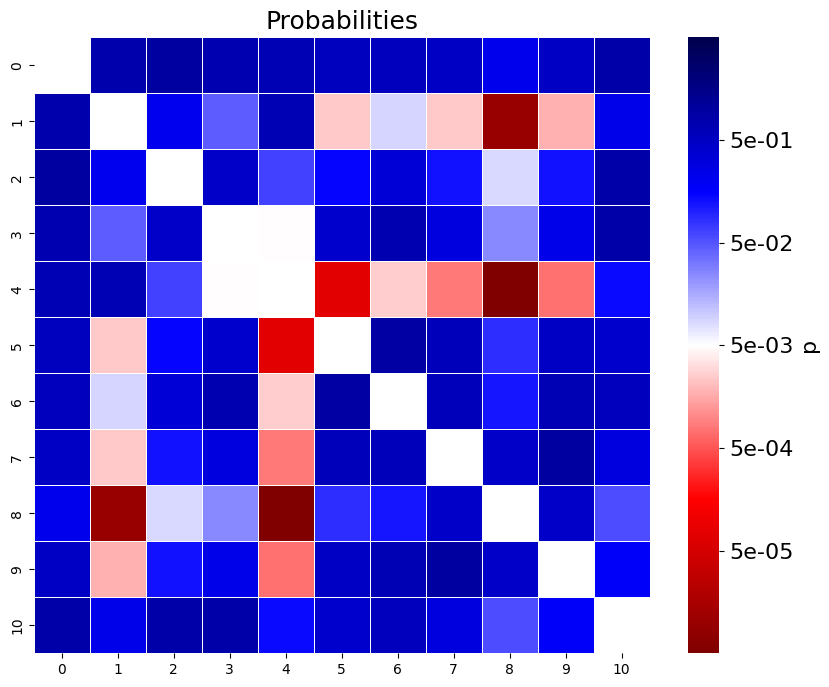

In [175]:
depth_chunks = ss_metrics.depth_chunk.unique()
n = len(depth_chunks)
p_matrix = np.zeros((n, n), dtype=float)

for i in range(n):
    p_matrix[i, i] = np.nan
    for j in range(i+1, n):
        x = ss_metrics.ssi[inclusion & (ss_metrics.depth_chunk == depth_chunks[i])]
        y = ss_metrics.ssi[inclusion & (ss_metrics.depth_chunk == depth_chunks[j])]
        _, p = st.ranksums(x, y)
        p_matrix[i, j] = p_matrix[j, i] = p

# at.heatmap_log_proba_plot(p_matrix, heatmap_labels=None, ticklabels=None, title="Probabilities", titlefontsize=18, xticklabelrotation=90, cbar_label="p", ax=None, ticklabelfontsize=16, figsize=(10, 8), significance_thresh=0.05, log=True, correct_comparisons=True)
at.heatmap_log_proba_plot(p_matrix)


In [255]:
pd.read_csv(dg_full_metrics_file).convert_dtypes().pref_dir_idx

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_2643/3789876785.py:1: DtypeWarning: Columns (3,27) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(dg_full_metrics_file).convert_dtypes().pref_dir_idx


0         9
1         4
2        11
3         6
4        10
         ..
52821     9
52822    10
52823    10
52824     1
52825     5
Name: pref_dir_idx, Length: 52826, dtype: Int64

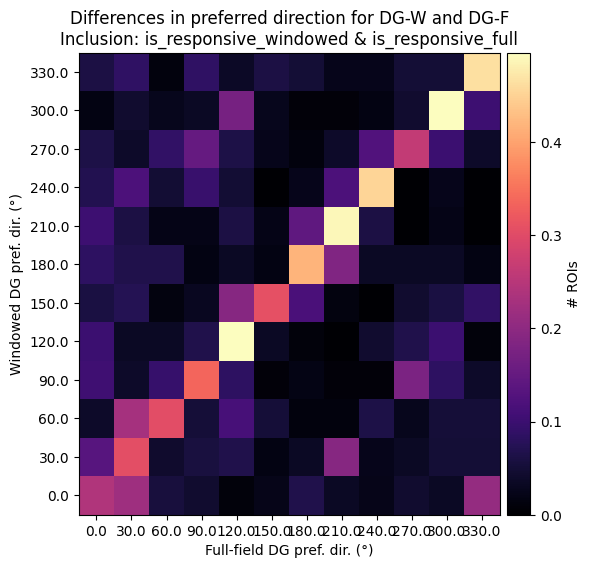

In [187]:
# Count cells that change preferred orientations
dir_list = dg_full[0].dir_list
n = len(dir_list)
pref_dir_w_vs_f = np.zeros((n, n))
# inclusion = (dg_full_metrics["is_responsive"]) & (dg_windowed_metrics["is_responsive"])
valid = ~dg_windowed_metrics.isna().any(axis=1) & ~dg_full_metrics.isna().any(axis=1)
inclusion = valid & (dg_full_metrics.z_score > 2) & (dg_windowed_metrics.z_score > 2)
# inclusion = (dg_windowed_metrics.is_responsive) & (dg_windowed_metrics.is_responsive)
# inclusion = (dg_windowed_metrics["is_responsive"]) & (dg_windowed_metrics["pref_ori_idx"] == dg_full_metrics["pref_ori_idx"])

for i in range(n):
    for j in range(n):
        count = np.count_nonzero(inclusion & (dg_windowed_metrics["pref_dir_idx"] == i) & (dg_full_metrics["pref_dir_idx"] == j))
        norm = np.count_nonzero(inclusion & (dg_windowed_metrics["pref_dir_idx"] == i))
        pref_dir_w_vs_f[i, j] = count / norm

fig, ax = plt.subplots(figsize=(6.5, 6), facecolor="white")

vmin = 0
vmax = np.percentile(pref_dir_w_vs_f, 99)
cax = ax.pcolormesh(pref_dir_w_vs_f, cmap="magma", vmin=vmin, vmax=vmax)
cb = fig.colorbar(cax, pad=0.015, label="# ROIs")

ax.set_title("Differences in preferred direction for DG-W and DG-F\nInclusion: is_responsive_windowed & is_responsive_full")
ax.set_xlabel("Full-field DG pref. dir. (°)")
ax.set_ylabel("Windowed DG pref. dir. (°)")
ticks = [i+0.5 for i in range(len(dir_list))]
ax.set_xticks(ticks=ticks, labels=dir_list)
ax.set_yticks(ticks=ticks, labels=dir_list)

In [188]:
dg_full_metrics["pref_ori"] = np.mod(dg_full_metrics.pref_dir, 180)
dg_windowed_metrics["pref_ori"] = np.mod(dg_windowed_metrics.pref_dir, 180)

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_1829/3403289981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg_full_metrics["pref_ori"] = np.mod(dg_full_metrics.pref_dir, 180)


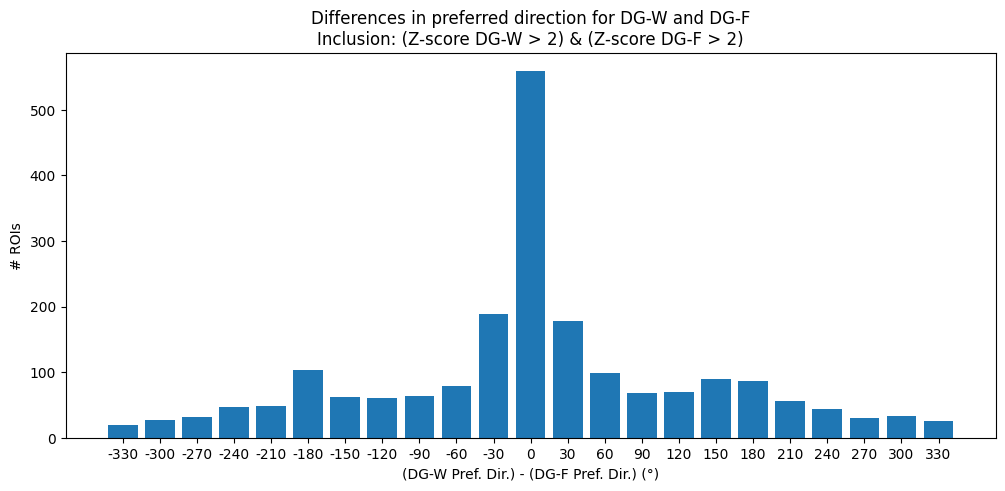

In [176]:
# Histogram of delta dir pref. across ROIs
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")
roi_delta_dir = (dg_windowed_metrics["pref_dir"] - dg_full_metrics["pref_dir"])[inclusion].values

delta_dir = sorted(np.unique(roi_delta_dir))
counts = [np.count_nonzero(roi_delta_dir == x) for x in delta_dir]
ax.bar([f"{d:.0f}" for d in delta_dir], counts)
ax.set_xlabel("(DG-W Pref. Dir.) - (DG-F Pref. Dir.) (°)")
ax.set_ylabel("# ROIs")
ax.set_title("Differences in preferred direction for DG-W and DG-F\nInclusion: (Z-score DG-W > 2) & (Z-score DG-F > 2)")
fig.savefig(f"{FIG_DIR}/diff_pref_dir.png")

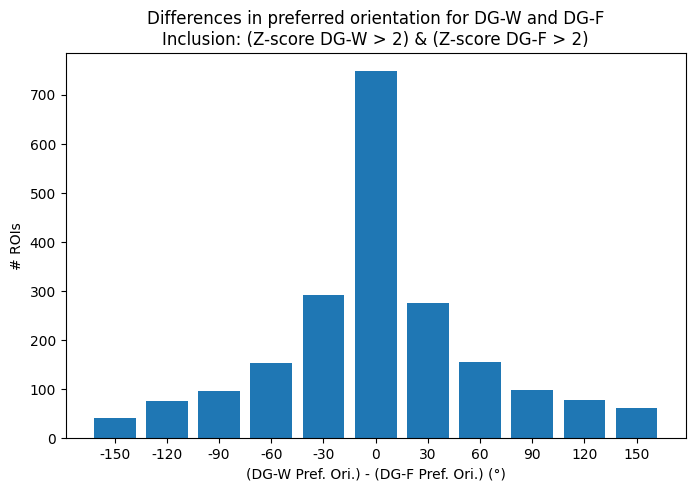

In [177]:
# Histogram of delta ori pref. across ROIs
fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
roi_delta_ori = (dg_windowed_metrics["pref_ori"] - dg_full_metrics["pref_ori"])[inclusion].values
delta_ori = sorted(np.unique(roi_delta_ori))

counts = [np.count_nonzero(roi_delta_ori == x) for x in delta_ori]
ax.bar([f"{d:.0f}" for d in delta_ori], counts)
ax.set_xlabel("(DG-W Pref. Ori.) - (DG-F Pref. Ori.) (°)")
ax.set_ylabel("# ROIs")
ax.set_title("Differences in preferred orientation for DG-W and DG-F\nInclusion: (Z-score DG-W > 2) & (Z-score DG-F > 2)")
fig.savefig(f"{FIG_DIR}/diff_pref_ori.png")